# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-03-06 14:57:46.596917: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


DEBUG - 2023-03-06 14:57:47,175 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.3.2
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta


from pymongo import ASCENDING

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
import mlflow
# mlflow.start_run(run_name='fetch trainset from db')

mlflow.set_tracking_uri("http://192.168.10.38:5000")
mlflow.set_experiment("analyzer-export-ts")

mlflow.tensorflow.autolog()


                 
# experiment_id = mlflow.create_experiment(
#     "Fetching training set from DB",
# #     tags={"version": "v1", "priority": "P1"},
# )                 
# experiment_id

### Prepare workdir

In [8]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

print('work_dir=', analyser.hyperparams.work_dir)
print('reports_path=', reports_path)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work
reports_path= /root/artem/analyser/training_reports


### Query DB for contact IDs

#### Load meta data CSV

In [9]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [10]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [11]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)
mlflow.log_param('metafile',  export_fn)
try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
    mlflow.log_param('last_doc_export_date',  lastdate)
    mlflow.log_metric('docs_in_metafile_start',  len(stats))
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'
stats

lastdate=2023-03-01 16:36:11.013000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-03-02 18:16:30.856094,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0,Бюджетное учреждение культуры,Общество с ограниченной ответственностью
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-03-02 18:16:30.870815,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0,Общество с ограниченной ответственностью,Некоммерческая унитарная организация
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-03-02 18:16:30.878077,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0,ООО,Общество с ограниченной ответственностью
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-03-02 18:16:30.890334,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5feb3e51bd24992aa3104108,db,a2a8b1642cf17567677b5c1d1015401b,2.3.14,2023-03-02 18:17:56.823023,14657.0,2020-12-29 17:34:05.506000+00:00,3.009000e+05,12.614537,1162.0,RUB,...,Insurance,1.0,2020-12-29 15:00:07.153000+00:00,True,CONTRACT,106.0,94.0,702.0,Общество с ограниченной ответственностью,Акционерное общество
5feb3e51bd24992aa3104122,db,ac8bae085299c3b9775e16489d7de24b,2.3.14,2023-03-02 18:17:57.058101,16277.0,2020-12-29 17:34:08.299000+00:00,7.000000e+09,22.669176,3045.0,RUB,...,GeneralContract,1.0,2020-12-29 15:04:28.271000+00:00,True,CONTRACT,69.0,34.0,2624.0,Общество с ограниченной ответственностью,ПАО
5feb3e50bd24992aa31040e1,db,874c75c5492a542cca8468ab78a13be9,2.3.14,2023-03-02 18:17:57.063210,1238.0,2020-12-29 17:35:01.616000+00:00,5.550000e+04,10.924156,196.0,RUB,...,GeneralContract,1.0,2020-12-29 14:44:06.461000+00:00,True,CONTRACT,71.0,11.0,90.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
5feb3e50bd24992aa31040e6,db,28c1365dd99c3e2afe1f2880101270a5,2.3.14,2023-03-02 18:17:57.072386,2675.0,2020-12-29 17:35:02.721000+00:00,1.900000e+08,19.062535,419.0,RUB,...,ParticipationInOtherOrganizations,1.0,2020-12-29 14:52:27.382000+00:00,True,CONTRACT,83.0,7.0,318.0,Общество с ограниченной ответственностью,Публичное акционерное общество


In [12]:
 
display(Markdown(f"#### {lastdate:%d.%m.%Y} -- дата последнего экспортированного документа"))


#### 01.03.2023 -- дата последнего экспортированного документа

# functions

In [13]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  stats.at[_id, 'value'] = None
  stats.at[_id, 'value_log1p'] = None
  stats.at[_id, 'value_span'] = None
  stats.at[_id, 'currency'] = None
    
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
    
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')
      stats.at[_id, 'org-1-type'] = _orgs[0].get('type', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')
        stats.at[_id, 'org-2-type'] = _orgs[1].get('type', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  stats.at[_id, 'user_correction_date'] = None
  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)

    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                        db
checksum                        da2dd54cdcc5b4480207c9def7741d14
version                                                   2.3.13
export_date                           2023-03-06 14:57:49.762933
len                                                          759
analyze_date                    2020-12-23 17:14:16.727000+00:00
value                                                   1.64e+06
value_log1p                                              14.3102
value_span                                                   128
currency                                                     RUB
org-1-name                                Газпромнефть-Снабжение
org-1-alias                                       Благотворитель
org-2-name                                   инициатив «Эпсилон»
org-2-alias                                      Благополучатель
subject                                                  Charity
subject confidence       

# load old json

In [14]:
import json
import re
from bson import json_util

_DEBUG = False
file_data=None

try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7f141df3cd30>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


fixed number: ['№ RP 16-06'] -->  ['RP 16-06']


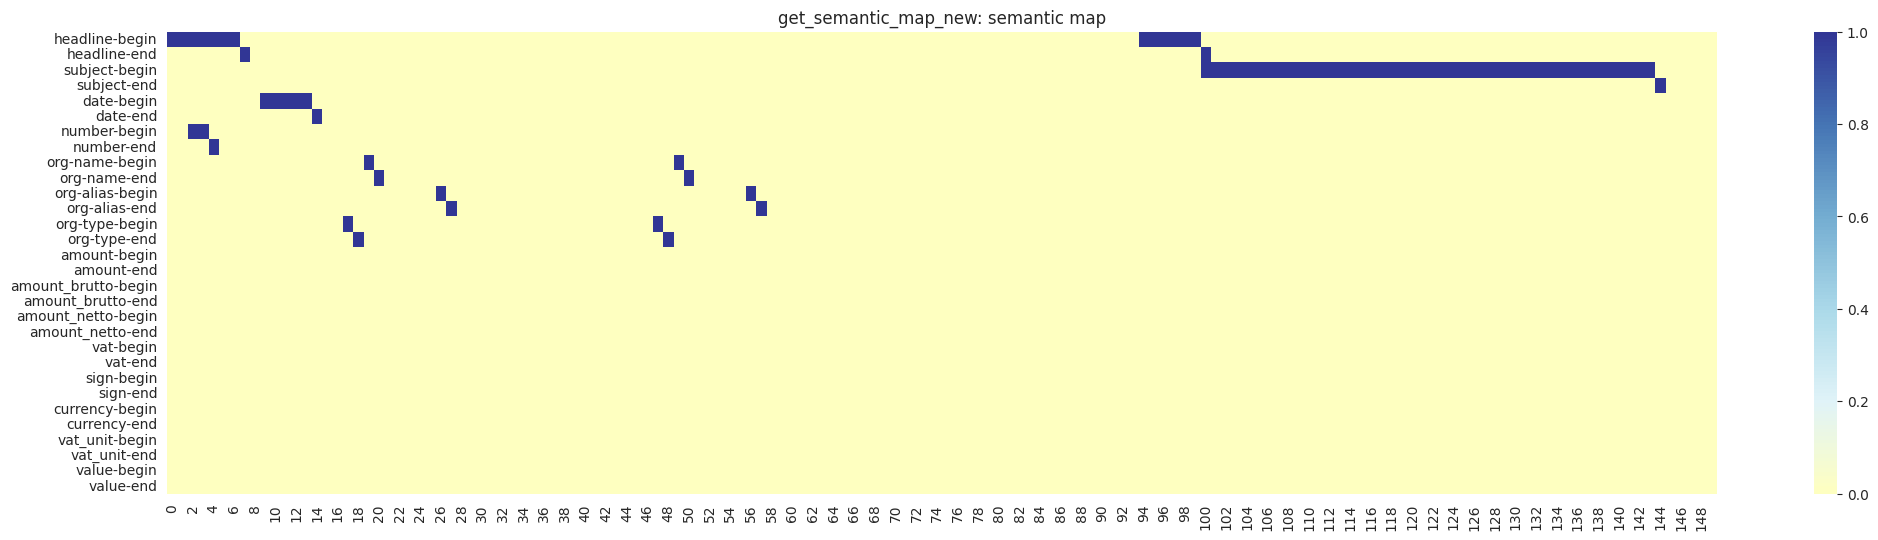

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [15]:

# TODO: import!!!

from tf_support.super_contract_model import get_semantic_map_new, \
        semantic_map_keys_contract, t_semantic_map_keys_common, t_semantic_map_keys_org, t_semantic_map_keys_price

# print("semantic_map_keys", semantic_map_keys[8:14])
# print("semantic_map_keys", semantic_map_keys[4:7])
# print("semantic_map_keys all", semantic_map_keys)
print("semantic_map_keys_contract", semantic_map_keys_contract)

print()
print()




# del get_semantic_map_new




if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:150], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

In [16]:
# len(sm_test)
# trimmed = sm_test[0:1200].values.T.copy()

In [17]:
# semantic_map_keys[4:7]
# position_enc = np.arange( 1,0, -0.0005)
# # position_enc
# max_pos = min(len(trimmed), len(position_enc))
# trimmed[0:max_pos][-1] = position_enc[0:max_pos]
# plot_embedding(trimmed , f'get_semantic_map_new: semantic map')

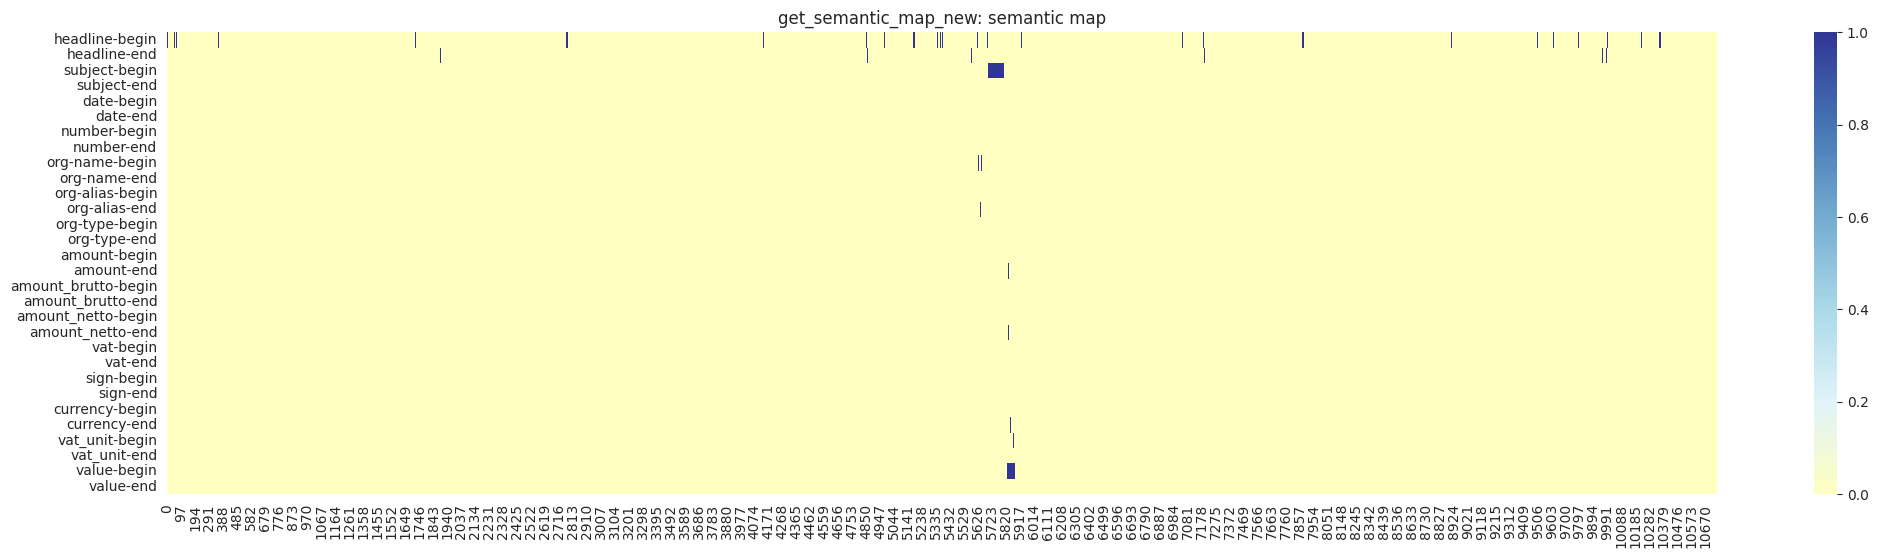

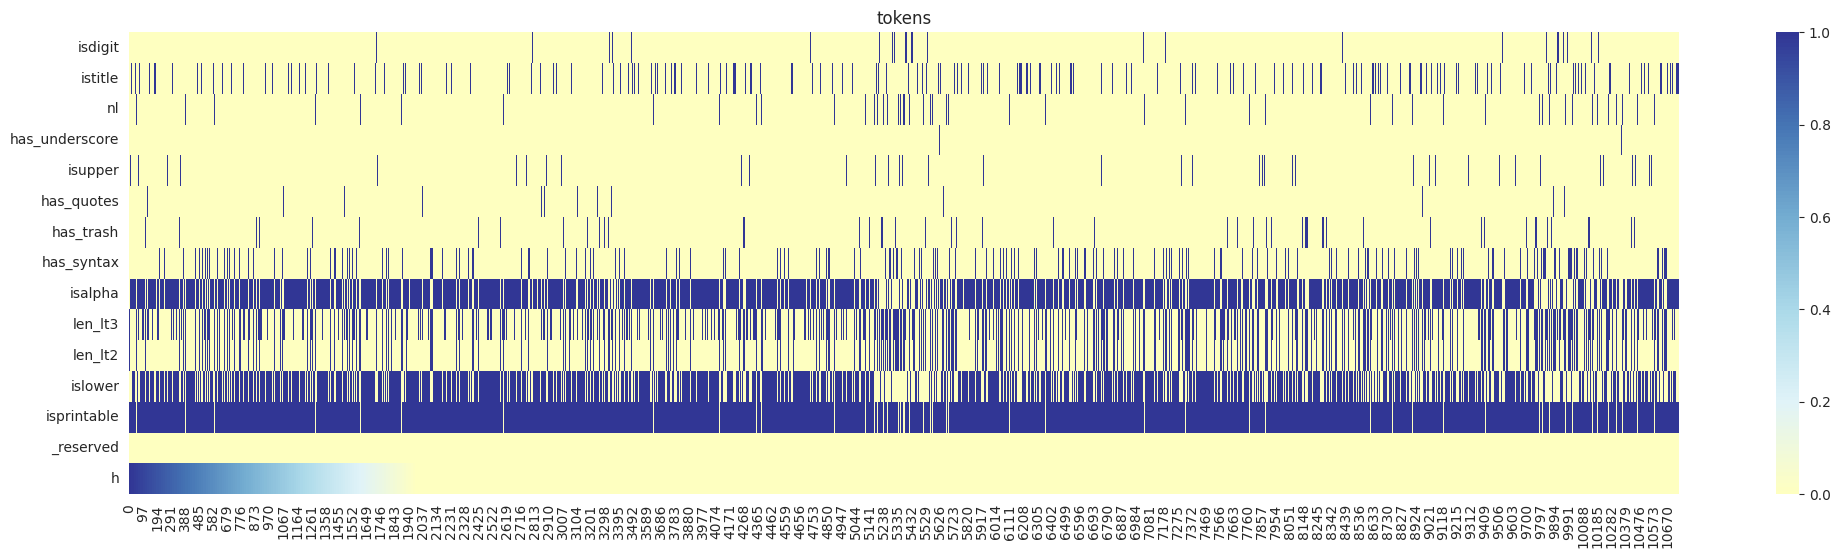

In [18]:
#test one
from analyser.headers_detector import get_tokens_features

d = get_doc_by_id(ObjectId('636dfd1473925c8dae26f910'))
if d is not None:
    jd = DbJsonDoc(d)
    semantic_map: DataFrame = get_semantic_map_new(jd)

    tokens_features = get_tokens_features(jd.get_tokens_map_unchaged().tokens)

    plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')
    plot_embedding(tokens_features, f'tokens')

In [19]:
tokens_features

,isdigit,istitle,nl,has_underscore,isupper,has_quotes,has_trash,has_syntax,isalpha,len_lt3,len_lt2,islower,isprintable,_reserved,h
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0000
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.9995
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.9990
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.9985
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.9980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0000
10748,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0000
10749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0000
10750,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0000


### Adding data from old json file to the stats table

In [20]:
# fff
files_dict = {}
files_cnt = 0
if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
            files_cnt+=1
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
mlflow.log_param('files_in_json',  files_cnt)            
stats.to_csv(export_fn, index=True)
# stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv



5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-03-02 18:16:30.856094,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0,Бюджетное учреждение культуры,Общество с ограниченной ответственностью
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-03-02 18:16:30.870815,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0,Общество с ограниченной ответственностью,Некоммерческая унитарная организация
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-03-02 18:16:30.878077,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0,ООО,Общество с ограниченной ответственностью
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-03-02 18:16:30.890334,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-03-06 14:58:06.262939,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0,NaN,NaN,NaN
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-03-06 14:58:14.335677,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,None,NaN,NaT,False,CONTRACT,0.0,26.0,NaN,Общество с ограниченной ответственностью,None
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-03-06 14:58:15.502823,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,None,...,None,NaN,NaT,False,CONTRACT,0.0,2.0,NaN,NaN,NaN
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-03-06 14:58:15.769653,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,None,...,None,NaN,NaT,False,CONTRACT,0.0,25.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью


In [21]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type


In [22]:
invalid = stats[stats['valid']==False]
print(f'{len(invalid)}: number of invalid records')
mlflow.log_metric('invalid records',  len(invalid))     
invalid

16: number of invalid records


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
63ce4b14e83d1ee490f40127,db,f452bb7473eed1a7c39d28cd60177bfc,23.01.23,2023-03-02 18:17:39.343799,61.0,2023-01-26 09:29:04.755000+00:00,NaN,NaN,NaN,NaN,...,Other,0.965543,NaT,False,ANNEX,1.0,1.0,0.0,NaN,NaN
5ded07184ddc27bcf92dd52a,file,942c7cdeefd0f13d75bd1298a268fd86,1.12.0,2023-03-06 14:57:58.655468,1899.0,2020-06-16 19:05:20.083000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-06 07:36:28.167000+00:00,False,CONTRACT,0.0,14.0,NaN,Общество с ограниченной ответственностью,Публичное акционерное общество
5ee188882281f29204c52293,file,0c9257578f5a5317ce2fb75a722b112f,1.11.2,2023-03-06 14:58:06.195960,419.0,2020-06-12 22:36:30.039000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:47:15.143000+00:00,False,CONTRACT,0.0,9.0,NaN,NaN,NaN
5ee188892281f29204c52297,file,e7069a417801ba0bd645c46552fb9a0e,1.11.2,2023-03-06 14:58:06.198221,413.0,2020-06-12 22:36:35.699000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:48:23.187000+00:00,False,CONTRACT,0.0,9.0,NaN,NaN,NaN
5ee188892281f29204c5229c,file,1c438e75302a679dfed4751219508463,1.11.2,2023-03-06 14:58:06.200461,419.0,2020-06-12 22:36:41.730000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:48:02.860000+00:00,False,CONTRACT,0.0,9.0,NaN,NaN,NaN
5ee188892281f29204c5229d,file,3fcece231096be2f8640a6fb97d681c7,1.11.2,2023-03-06 14:58:06.202699,416.0,2020-06-12 22:36:47.363000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:46:58.837000+00:00,False,CONTRACT,0.0,9.0,NaN,NaN,NaN
5ee188892281f29204c522a0,file,5768718d20b1a818fc35a0daa3918c55,1.11.2,2023-03-06 14:58:06.206796,1382.0,2020-06-12 22:37:04.897000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:48:42.381000+00:00,False,CONTRACT,0.0,3.0,NaN,NaN,NaN
5ee1888a2281f29204c522a5,file,c50c5b6a442127b7898c122e913c90e8,1.11.2,2023-03-06 14:58:06.210654,1286.0,2020-06-12 22:37:21.034000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:50:49.163000+00:00,False,CONTRACT,0.0,5.0,NaN,NaN,NaN
5ee1888a2281f29204c522a9,file,5ae27a8a2e8a1d8a8641932e7b7aa7f3,1.11.2,2023-03-06 14:58:06.214506,1286.0,2020-06-12 22:37:37.208000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:50:13.757000+00:00,False,CONTRACT,0.0,5.0,NaN,NaN,NaN
5ee1888b2281f29204c522ac,file,b0684e63ee2834d19076d56c7a703c28,1.11.2,2023-03-06 14:58:06.219174,1793.0,2020-06-12 22:37:58.730000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:49:00.403000+00:00,False,CONTRACT,0.0,14.0,NaN,NaN,NaN


In [23]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [24]:

# from datetime import timedelta
# if True:

lastdate  += relativedelta(days=-15)  
# lastdate = datetime.combine(lastdate, datetime.min.time())
# lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-02-14 16:36:11.013000+0000', tz='UTC')

In [25]:
report_date = datetime.now() + relativedelta(days=-2)  
report_date

datetime.datetime(2023, 3, 4, 14, 58, 19, 121857)

In [26]:
yesterday = datetime.now() + relativedelta(days=-1)  
# {'analysis.analyze_timestamp': {'$gt': yesterday}},



query = {'user.updateDate': {'$gt': report_date}}
db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
                               ).limit(5000)

_r = list([i for i in res])
# print(res[0])
_s = f"#### {len(_r)} -- всего размечено документов после {report_date:%d.%m.%Y}"
mlflow.log_metric('fresh_user_docs_in_db',  len(_r))     
display(Markdown(_s))
yseterday_ids=[i["_id"] for i in _r]


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### 24 -- всего размечено документов после 04.03.2023

In [27]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
mlflow.log_metric('fresh_docs_in_db',  len(res))     
# print(res[0])
_s = f"#### {len(res)} -- всего проанализировано новых документов после {lastdate:%d.%m.%Y}"
display(Markdown(_s))

res[:4]

#### 427 -- всего проанализировано новых документов после 14.02.2023

[{'_id': ObjectId('5e2ea6ca73698e191112bee8'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 15,
  'user': {'updateDate': datetime.datetime(2023, 3, 3, 6, 53, 47, 400000)}},
 {'_id': ObjectId('5ec2b8d8665f7603e03b121c'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 3, 3, 6, 52, 26, 474000)}},
 {'_id': ObjectId('5ec2b8da665f7603e03b1265'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 3, 3, 6, 39, 26, 767000)}},
 {'_id': ObjectId('5ec2b8da665f7603e03b126a'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 3, 3, 9, 51, 15, 614000)}}]

# Prepare training set

In [28]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(f"{len(new_docs_ids)=}")
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

len(new_docs_ids)=427


In [29]:
stats.columns

Index(['source', 'checksum', 'version', 'export_date', 'len', 'analyze_date',
       'value', 'value_log1p', 'value_span', 'currency', 'org-1-name',
       'org-1-alias', 'org-2-name', 'org-2-alias', 'subject',
       'subject confidence', 'user_correction_date', 'valid', 'documentType',
       'subj_len', 'headers', 'subject_pos', 'org-1-type', 'org-2-type'],
      dtype='object')

In [30]:
# for i in (1,2):
#     for key in ['alias', 'name', 'type']:
#         k=f'org-{i}-{key}'
#         stats2[k] = None

In [31]:
all_db_docs_ids = stats[stats.source=='db'].index.values

In [32]:


def add_to_stats_list(docs_ids, stats):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
        try:
            jd = DbJsonDoc(d)
#             add_stats_record(jd, stats)
        except Exception as e:
            print(f'missing {oid=}')
            stats = stats.drop(index=oid)
            print (e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
#--
# add_to_stats_list(all_db_docs_ids, stats)     


add_to_stats_list(new_docs_ids, stats)     

stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
mlflow.log_metric('docs_in_metafile_result',  len(stats))
stats

0 of 427
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


100 of 427
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


200 of 427
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


300 of 427
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


400 of 427
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-03-02 18:16:30.856094,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0,Бюджетное учреждение культуры,Общество с ограниченной ответственностью
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-03-02 18:16:30.870815,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0,Общество с ограниченной ответственностью,Некоммерческая унитарная организация
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-03-02 18:16:30.878077,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0,ООО,Общество с ограниченной ответственностью
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-03-02 18:16:30.890334,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-03-06 14:58:06.262939,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,None,...,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0,NaN,NaN,NaN
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-03-06 14:58:14.335677,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,None,NaN,NaT,False,CONTRACT,0.0,26.0,NaN,Общество с ограниченной ответственностью,None
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-03-06 14:58:15.502823,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,None,...,None,NaN,NaT,False,CONTRACT,0.0,2.0,NaN,NaN,NaN
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-03-06 14:58:15.769653,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,None,...,None,NaN,NaT,False,CONTRACT,0.0,25.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью


## Headers

In [33]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
s =s[s['headers'].isna()]
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s.index)
print(len(_ids))
# add_to_stats_list(_ids, stats)     
# print(f'saving to {export_fn}; {len(stats)} records')
# stats.to_csv(export_fn, index=True)
del _ids
s

13


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
637397e2a8eb8dc64b37543b,db,83147eced7836488537078f0069887b6,3.0.0,2022-12-10 06:23:51.702406+00:00,128.0,2022-11-15 16:46:00.486000+00:00,NaN,NaN,NaN,NaN,...,Other,0.977535,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543c,db,cc1fb71b2995d7931a8304337c4875af,3.0.0,2022-12-10 06:23:51.704858+00:00,960.0,2022-11-15 16:46:03.090000+00:00,NaN,NaN,NaN,NaN,...,Other,0.985890,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543d,db,a132be65b99d9d99bfa55021264d91f7,3.0.0,2022-12-10 06:23:51.706096+00:00,305.0,2022-11-15 16:46:04.549000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984468,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543f,db,a826bef5d8588f48d4ce1742dc9c0549,3.0.0,2022-12-10 06:23:51.707106+00:00,133.0,2022-11-15 16:46:05.482000+00:00,NaN,NaN,NaN,NaN,...,Other,0.977728,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b375440,db,55735a4bf73f987e5dcbc453c99a2116,3.0.0,2022-12-10 06:23:51.709500+00:00,970.0,2022-11-15 16:46:29.413000+00:00,NaN,NaN,NaN,NaN,...,Other,0.985893,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b375441,db,849215296ad06199a577a1f97b4d740d,3.0.0,2022-12-10 06:23:51.710860+00:00,335.0,2022-11-15 16:46:38.242000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984553,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543a,db,460edb48ee9f32013d0ba1c44ded7032,3.0.0,2022-12-10 06:23:51.716618+00:00,1982.0,2022-11-15 16:46:41.324000+00:00,75000.0,11.225257,497.0,RUB,...,Service,0.987508,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637397e2a8eb8dc64b37543e,db,9e1842a154bc62127d11471e542ce4f6,3.0.0,2022-12-10 06:23:51.722416+00:00,1985.0,2022-11-15 16:47:28.506000+00:00,75000.0,11.225257,495.0,RUB,...,Service,0.987411,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637e11d66a07f3e980b2bfbf,db,17ea48a46bd896617b8399c313cf4422,3.0.0,2022-12-10 06:23:52.817416+00:00,11594.0,2022-11-23 15:33:36.150000+00:00,19891503.0,16.805803,885.0,RUB,...,Service,0.631916,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN
637e11d76a07f3e980b2bfc0,db,bdc061481685cc60e0977d162e36e891,3.0.0,2022-12-10 06:23:52.908066+00:00,11595.0,2022-11-23 15:38:42.374000+00:00,190891503.0,19.067216,885.0,RUB,...,Service,0.628359,NaT,True,undefined,NaN,NaN,NaN,NaN,NaN


In [34]:
stats = stats[stats.valid!=False]
len(stats)

3098

### Put all to lower

In [35]:
stats2 = stats.copy()

if False:
    for i in (1,2):
        for key in ['alias', 'name', 'type']:
            k=f'org-{i}-{key}'
            stats2[k] = stats2[k].str.lower()
        
        
# stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
# stats2['org-1-name'] = stats2['org-1-name'].str.lower()
# stats2['org-2-name'] = stats2['org-2-name'].str.lower()

# stats2['org-1-type'] = stats2['org-1-type'].str.lower()
# stats2['org-2-type'] = stats2['org-2-type'].str.lower()
stats2

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Service,1.0,2023-02-06 10:57:02.292000+00:00,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-03-02 18:16:30.856094,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0,158.0,Бюджетное учреждение культуры,Общество с ограниченной ответственностью
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-03-02 18:16:30.870815,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0,121.0,Общество с ограниченной ответственностью,Некоммерческая унитарная организация
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-03-02 18:16:30.878077,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0,334.0,ООО,Общество с ограниченной ответственностью
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-03-02 18:16:30.890334,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0,353.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5feb3e51bd24992aa3104108,db,a2a8b1642cf17567677b5c1d1015401b,2.3.14,2023-03-02 18:17:56.823023,14657.0,2020-12-29 17:34:05.506000+00:00,3.009000e+05,12.614537,1162.0,RUB,...,Insurance,1.0,2020-12-29 15:00:07.153000+00:00,True,CONTRACT,106.0,94.0,702.0,Общество с ограниченной ответственностью,Акционерное общество
5feb3e51bd24992aa3104122,db,ac8bae085299c3b9775e16489d7de24b,2.3.14,2023-03-02 18:17:57.058101,16277.0,2020-12-29 17:34:08.299000+00:00,7.000000e+09,22.669176,3045.0,RUB,...,GeneralContract,1.0,2020-12-29 15:04:28.271000+00:00,True,CONTRACT,69.0,34.0,2624.0,Общество с ограниченной ответственностью,ПАО
5feb3e50bd24992aa31040e1,db,874c75c5492a542cca8468ab78a13be9,2.3.14,2023-03-02 18:17:57.063210,1238.0,2020-12-29 17:35:01.616000+00:00,5.550000e+04,10.924156,196.0,RUB,...,GeneralContract,1.0,2020-12-29 14:44:06.461000+00:00,True,CONTRACT,71.0,11.0,90.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью
5feb3e50bd24992aa31040e6,db,28c1365dd99c3e2afe1f2880101270a5,2.3.14,2023-03-02 18:17:57.072386,2675.0,2020-12-29 17:35:02.721000+00:00,1.900000e+08,19.062535,419.0,RUB,...,ParticipationInOtherOrganizations,1.0,2020-12-29 14:52:27.382000+00:00,True,CONTRACT,83.0,7.0,318.0,Общество с ограниченной ответственностью,Публичное акционерное общество


# Statistics
### Collecting org types

In [36]:
stats2['subject'].value_counts()

Service                              1472
Other                                 478
Deal                                  332
Renting                               158
GeneralContract                       153
Loans                                 135
DealIntellectualProperty               71
Charity                                70
AgencyContract                         70
Insurance                              52
RealEstate                             24
RealEstateTransactions                 21
BankGuarantees                         17
ParticipationInOtherOrganizations      17
SecuritiesTransactions                 13
PledgeEncumbrance                      10
AssetTransactions                       2
BigDeal                                 2
EmployeeContracts                       1
Name: subject, dtype: int64

In [37]:
stats2['org-1-alias'].value_counts()

Заказчик           1066
Исполнитель         422
Покупатель          265
Поставщик           112
Арендатор            81
                   ... 
Даритель              1
Ромашка               1
оператор              1
Клуб                  1
Газпромнефть-КС       1
Name: org-1-alias, Length: 94, dtype: int64

In [38]:
stats2['org-2-alias'].value_counts()

Исполнитель      871
Заказчик         443
Поставщик        217
Подрядчик        175
Покупатель       172
                ... 
ГАРАНТ             1
Владелец           1
SUN                1
Актуарий           1
ПРИОБРЕТАТЕЛЬ      1
Name: org-2-alias, Length: 102, dtype: int64

In [39]:
score_column_name = "score"

In [40]:


def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

3098


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-06 14:57:59.719721,5953.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,True,CONTRACT,51.0,14.0,NaN,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,0.201131
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-06 14:58:02.840701,1373.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,True,CONTRACT,106.0,10.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,0.609175
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,True,CONTRACT,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,0.616928
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4892.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,True,CONTRACT,121.0,11.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,0.676329
639083617fc8981f6e29f2e9,db,daa1fec657ec24b7314d0ef2d3a9f411,22.12.7,2023-03-02 18:17:30.054561,3139.0,2022-12-08 01:47:27.623000+00:00,1.550000e+10,23.464106,278.0,RUB,...,True,CONTRACT,78.0,12.0,150.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,0.710202
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3139.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,True,CONTRACT,81.0,12.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,0.710202
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-03-06 14:57:59.337626,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,True,CONTRACT,30.0,5.0,NaN,Акционерное общество,Муниципальное автономное дошкольное образовате...,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,0.732855
63908ca4a1bded13e629f2e9,db,daa1fec657ec24b7314d0ef2d3a9f411,23.01.23,2023-03-02 18:17:29.357107,3139.0,2023-01-27 16:02:07.552000+00:00,5.000000e+09,22.332704,412.0,RUB,...,True,CONTRACT,85.0,12.0,144.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,0.746182
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-03-02 18:17:44.744332,8535.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,True,CONTRACT,53.0,12.0,100.0,Акционерное общество,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,0.753434
636cf11a73925c8dae26f904,db,6a87cd84af3ae0dce2acc4177a9de9e3,3.0.0,2023-03-02 18:17:15.625560,1362.0,2022-11-10 15:40:45.019000+00:00,6.224100e+09,22.551695,555.0,RUB,...,True,CONTRACT,112.0,3.0,361.0,Публичное акционерное общество,Акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/636c...,False,1.108791


In [41]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [42]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,valid,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score
5fc7a047c54bc33809e26372,db,82137d4b0ded9b81b1d12f4d9e98c383,2.0.5,2023-03-02 18:16:54.230167,49340.0,2020-12-03 08:07:48.699000+00:00,90619807.0,18.322183,4503.0,RUB,...,True,CONTRACT,44.0,53.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,True,3.331408e+03
5fca2acd9083b679224c77da,db,6b64d52e5ecb4941696164ed4950e735,2.0.5,2023-03-02 18:16:58.385566,49040.0,2020-12-10 10:40:36.652000+00:00,90619807.0,18.322183,4207.0,RUB,...,True,CONTRACT,44.0,44.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,2.973297e+01
5fca2ac89083b679224c7786,db,8175a19a30e81fda3cc0f92e46a7dcfe,2.0.5,2023-03-02 18:17:46.972820,43930.0,2020-12-10 06:21:54.242000+00:00,11285139.0,16.238997,4251.0,RUB,...,True,CONTRACT,255.0,50.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.354720e+01
5fca2ac79083b679224c7750,db,7d43d92cdf325320741e51c45199ae19,2.0.5,2023-03-02 18:17:56.481084,41250.0,2020-12-10 09:05:55.962000+00:00,24680665.0,17.021531,4253.0,RUB,...,True,CONTRACT,258.0,40.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.200493e+01
5f09a55a138e9184feef1f3d,file,1a9db8f1670e2e976b777841a0cd3412,2.0.4,2023-03-06 14:58:17.408983,39860.0,2020-10-04 10:50:52.531000+00:00,NaN,NaN,NaN,None,...,True,CONTRACT,118.0,4.0,NaN,Общество с ограниченной ответственностью,None,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,False,1.511774e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638f0a7fb1363747e929f2e8,db,7b37265518b1e7f9c172a509fd2cc805,22.12.6,2023-03-02 18:17:27.403875,60.0,2022-12-06 12:27:42.812000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,39.0,1.0,10.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,6.665437e+07
63ce4a78e83d1ee490f3f98d,db,43b8b6ba8fcb4745350abaa37d643942,23.01.23,2023-03-02 18:17:40.844035,60.0,2023-01-23 21:43:18.848000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,59.0,1.0,NaN,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07
6130d65d4f22ff1b7e02fd0e,db,a3326b0583f9330c1c3735e393347779,2.4.6,2023-03-02 18:17:07.738831,60.0,2021-09-02 16:55:40.994000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,2.0,1.0,5.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6130...,True,6.665437e+07
63ce4a75e83d1ee490f3f930,db,906bed780f79e9dbe8135d2077f73718,23.01.23,2023-03-02 18:17:40.835930,50.0,2023-01-23 21:24:56.490000+00:00,NaN,NaN,NaN,NaN,...,True,ANNEX,27.0,1.0,28.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07


In [43]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject'], row['headers']  ]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

3098


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,documentType,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score,hash
638085b66a07f3e980b2c814,db,c1d8fd0bdd2760de803ca9bdda391012,3.0.0,2023-03-02 18:17:22.843769,1080.0,2022-11-25 12:34:44.532000+00:00,200000.00,12.206078,276.0,RUB,...,CONTRACT,51.0,8.0,108.0,Общество с ограниченной ответственностью,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,2.539390e+02,-9.211039e+18
63c506dde2456d59975e1476,db,6b04f276d76f23a9839d4ad31b4babc3,23.01.04,2023-03-02 18:17:33.147276,260.0,2023-01-16 12:09:30.367000+00:00,NaN,NaN,NaN,рублей,...,ANNEX,40.0,2.0,123.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,8.740989e+05,-9.198600e+18
63c506bfe2456d59975e114d,db,76a511e07213197b6d8d4aa19564c02f,23.01.04,2023-03-02 18:17:32.635811,14070.0,2023-01-16 11:38:28.595000+00:00,NaN,NaN,NaN,рублей,...,ANNEX,156.0,19.0,150.0,Общество с ограниченной ответственностью,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,2.002505e+06,-9.191243e+18
638085936a07f3e980b2c52d,db,76a511e07213197b6d8d4aa19564c02f,3.0.0,2023-03-02 18:17:24.448077,14070.0,2022-11-25 15:59:22.073000+00:00,NaN,NaN,NaN,NaN,...,ANNEX,37.0,19.0,150.0,Общество с ограниченной ответственностью,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,True,2.002505e+06,-9.191243e+18
5edbc66cda3678279fbcaff3,file,58b81927f6f8ad9abdf95e8d5ca965a9,2.0.2,2023-03-06 14:58:05.707438,7220.0,2020-07-14 08:45:18.216000+00:00,929494.81,13.742398,445.0,RUB,...,CONTRACT,54.0,20.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,7.518338e+01,-9.189497e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb6750a33c72547b755011b,db,e9ce362ea4896bc1fca93d4f517329ea,2.0.5,2023-03-02 18:16:42.722358,5160.0,2020-11-19 14:31:17.132000+00:00,2833333.33,14.856965,539.0,RUB,...,CONTRACT,101.0,23.0,220.0,Акционерное общество,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,False,5.430239e+01,9.194745e+18
63ce4a0ae83d1ee490f3f340,db,04a102c771cc132b9a39cc7dad3c04e2,23.01.23,2023-03-02 18:17:40.495153,2940.0,2023-01-23 16:33:29.987000+00:00,NaN,NaN,NaN,NaN,...,ANNEX,125.0,8.0,813.0,Общество с ограниченной ответственностью,Закрытое акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.718063e+06,9.195288e+18
63c506d7e2456d59975e13c6,db,930302ef2bebe37ff6c74f153604405a,23.01.04,2023-03-02 18:17:37.375405,3990.0,2023-01-16 13:57:36.850000+00:00,100000.00,11.512935,835.0,RUB,...,CONTRACT,89.0,13.0,100.0,Общество с ограниченной ответственностью,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,5.384552e+03,9.199165e+18
5fb3b9a800881c332b567442,db,068988174e19aa487060b98cedb87e45,2.4.4,2023-03-02 18:17:06.146856,4710.0,2021-07-30 16:45:07.085000+00:00,NaN,NaN,NaN,NaN,...,ANNEX,1.0,20.0,2011.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,8.517315e+05,9.206853e+18


In [44]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

3098

In [45]:
# dups.duplicated(subset=['hash'])

### Drop duplicates

In [46]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
# dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

mlflow.log_metric('duplicates',  len(stats) - len(dups_s))
mlflow.log_metric('unique_docs',  len(dups_s))

2442


## Remove rare subjects and very long docs

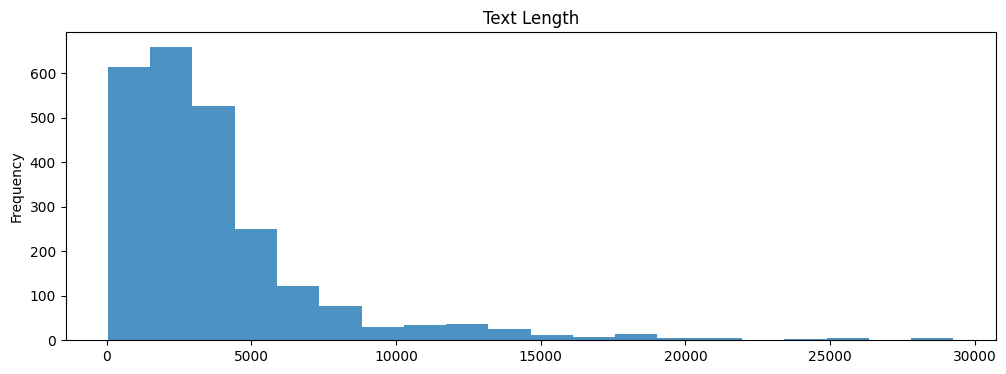

In [47]:
plt.figure(figsize=(12, 4))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.20113069681782658


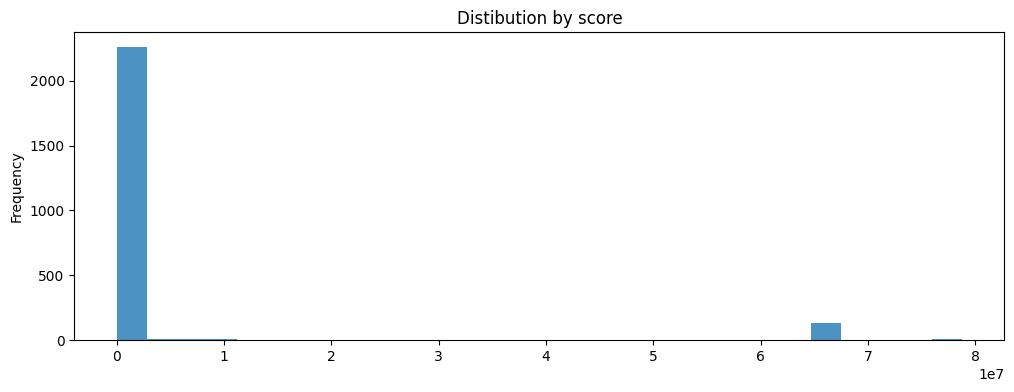

In [48]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 4))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [49]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5e58df7823869ee43538823d file GeneralContract 31090.0
excluding 5fbf75c75d05d73d0295fac0 db GeneralContract 38360.0
excluding 5fca2acd9083b679224c77da db GeneralContract 49040.0
excluding 5fca2ac79083b679224c7750 db GeneralContract 41250.0
excluding 5fca2ac89083b679224c7786 db GeneralContract 43930.0
excluding 5f9672f182451803b5001df7 db GeneralContract 31170.0
excluding 5fca2ac79083b679224c774f db GeneralContract 39310.0
excluding 5fca2ac99083b679224c77b0 db GeneralContract 39000.0
excluding 5e5de70d01c6c73c19eebd4a file GeneralContract 31090.0
excluding 5fc7a047c54bc33809e26372 db Service 49340.0


excluding 5f09a55a138e9184feef1f3d file Service 39860.0
excluding 615e9e978f3b0514f3f42413 db Loans 35800.0
excluding docs with rare subj
excluding 5feb3e50bd24992aa31040df db AssetTransactions
excluding 5dee80604ddc27bcf92dd88e file EmployeeContracts
excluding 5fbbbd1ba2b4551c06107a3d db BigDeal
excluding 6166dbc387f1d9065bb8b937 db AssetTransactions


Service                              1172
Other                                 397
Deal                                  270
Renting                               117
GeneralContract                       113
Loans                                  91
AgencyContract                         60
DealIntellectualProperty               51
Charity                                43
Insurance                              38
RealEstate                             24
RealEstateTransactions                 15
BankGuarantees                         11
SecuritiesTransactions                  9
ParticipationInOtherOrganizations       9
PledgeEncumbrance                       6
Name: subject, dtype: int64


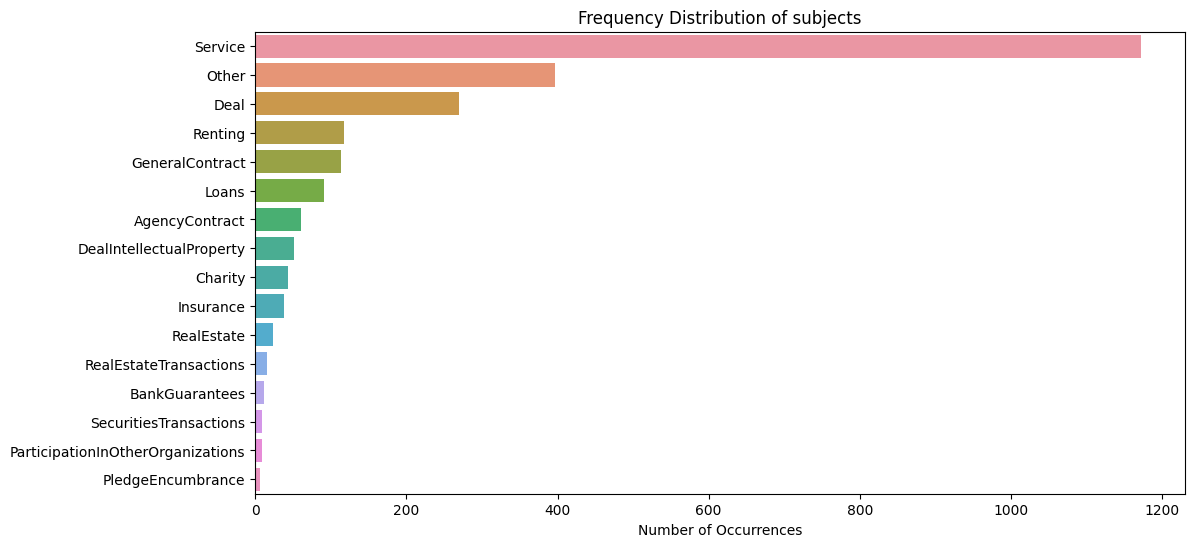

In [50]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [51]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate:%d.%m.%Y}"
display(Markdown(_s))


dups_s

### 2426 - Всего новых документов в обучающем наборе на 14.02.2023

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-06 14:57:59.719721,5950.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,51.0,14.0,NaN,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,2.011307e-01,-3.676084e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-06 14:58:02.840701,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,106.0,10.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.091754e-01,4.114182e+18,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.169281e-01,-2.326586e+18,1.0
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,121.0,11.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,6.763288e-01,-3.199301e+18,4.0
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,81.0,12.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,7.102020e-01,-2.951830e+18,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6130d65d4f22ff1b7e02fd06,db,5439d9e2947703f8ddfd8dfcacf70812,2.4.6,2023-03-02 18:17:07.733416,70.0,2021-09-02 16:55:39.995000+00:00,NaN,NaN,NaN,NaN,...,5.0,1.0,4.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6130...,True,7.878661e+07,-8.889024e+17,1.0
6166e28787f1d9065bb8b949,db,2f8ca4051ac3f51a7bf796627406fd4c,2.5.0,2023-03-02 18:17:11.353487,970.0,2021-10-13 16:46:44.849000+00:00,NaN,NaN,NaN,NaN,...,22.0,6.0,27.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6166...,True,7.878661e+07,1.654519e+18,1.0
63ce4a5ee83d1ee490f3f7ea,db,a4560b85845f310fab3866b5e756e3ee,23.01.23,2023-03-02 18:17:40.779840,90.0,2023-01-23 19:44:53.334000+00:00,NaN,NaN,NaN,рублей,...,9.0,1.0,89.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.878661e+07,5.857173e+16,1.0


In [52]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [53]:
dups_s[dups_s['unseen']]

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
63c506ace2456d59975e0f9f,db,2ff69a29f2a6f16826a6e68dc6cc1d22,23.01.04,2023-03-02 18:17:38.849251,430.0,2023-01-16 14:43:58.035000+00:00,5.500000e+07,17.822844,172.0,RUB,...,10.0,5.0,136.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,4.420148e+01,-4.447295e+18,1.0
5efe924d777d4b67a92d55b0,file,c056d218b8ae1d56747afd23ac3cf10f,2.0.0,2023-03-06 14:58:11.439865,17580.0,2020-07-03 12:29:32.528000+00:00,1.865870e+08,19.044408,2372.0,RUB,...,11.0,76.0,NaN,Акционерное общество,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,5.408784e+01,-6.089485e+18,1.0
5f86efe91115a777cc39a220,file,81489262f6e47f8fde2b23a21536f0c5,2.0.5,2023-03-06 14:58:18.857481,7780.0,2020-10-14 20:59:44.891000+00:00,8.878160e+07,18.301690,2383.0,RUB,...,73.0,19.0,NaN,Общество с ограниченной ответственностью,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5f86...,True,5.745259e+01,-2.789753e+18,1.0
5edbadd9da3678279fbcab15,file,dd14f75369397ffa2907a1abd5b37307,1.22.1,2023-03-06 14:58:02.223280,4520.0,2020-06-30 19:44:30.929000+00:00,9.583333e+06,16.075536,1092.0,RUB,...,125.0,14.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,True,7.052822e+01,6.635039e+18,1.0
60d1bbffc07bc76a2196cb47,db,803e4dc51e7c76b60447a3ceff3da6c1,2.4.2,2023-03-02 18:17:04.326658,2490.0,2021-06-22 13:37:32.513000+00:00,1.666667e+08,18.931506,287.0,RUB,...,21.0,16.0,118.0,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/60d1...,True,7.530815e+01,3.065518e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6130d65d4f22ff1b7e02fd06,db,5439d9e2947703f8ddfd8dfcacf70812,2.4.6,2023-03-02 18:17:07.733416,70.0,2021-09-02 16:55:39.995000+00:00,NaN,NaN,NaN,NaN,...,5.0,1.0,4.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6130...,True,7.878661e+07,-8.889024e+17,1.0
6166e28787f1d9065bb8b949,db,2f8ca4051ac3f51a7bf796627406fd4c,2.5.0,2023-03-02 18:17:11.353487,970.0,2021-10-13 16:46:44.849000+00:00,NaN,NaN,NaN,NaN,...,22.0,6.0,27.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6166...,True,7.878661e+07,1.654519e+18,1.0
63ce4a5ee83d1ee490f3f7ea,db,a4560b85845f310fab3866b5e756e3ee,23.01.23,2023-03-02 18:17:40.779840,90.0,2023-01-23 19:44:53.334000+00:00,NaN,NaN,NaN,рублей,...,9.0,1.0,89.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.878661e+07,5.857173e+16,1.0


In [54]:
%%time
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    {"user.attributes_tree": {"$ne": None}},
#       {'user.updateDate': {'$gt': lastdate}}    
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего документов, которые размечены человеком : {len(res)}"
display(Markdown(_s))

# res[:4]



/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего документов, которые размечены человеком : 1166

CPU times: user 18.6 ms, sys: 324 µs, total: 19 ms
Wall time: 177 ms


# 🤦 Find markup errors

In [55]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 1166


In [56]:
errors_report_file_prefix = "user_markup_errors"
errors_report_metric_prefix = "user"
user_docs_ids = user_docs_ids
%run -i -t /root/artem/analyser/trainsets/validate_markup.ipynb
del user_docs_ids

DEBUG - 2023-03-06 14:58:26,864 - retrain_ipynb - --=logging started=--


DEBUG - 2023-03-06 14:58:26,864 - retrain_ipynb - --=logging started=--


Running on :platform.processor()='x86_64'
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports
['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=
Number of contract IDs for validation (set ouside) is 1166
CPU times: user 18 µs, sys: 2 µs, total: 20 µs
Wall time: 22.9 µs
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.3 µs


#### Всего ошибок: 1896.0 в 1166 документах -- (1.6260720411663807 на документ)

CPU times: user 4.93 s, sys: 373 ms, total: 5.3 s
Wall time: 7.75 s
<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/c3fa6131cb804c36b979db6bf653a669/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='c3fa6131cb804c36b979db6bf653a669', run_name='upbeat-ape-337', run_uuid='c3fa6131cb804c36b979db6bf653a669', start_time=1678103906874, status='RUNNING', user_id='root'>


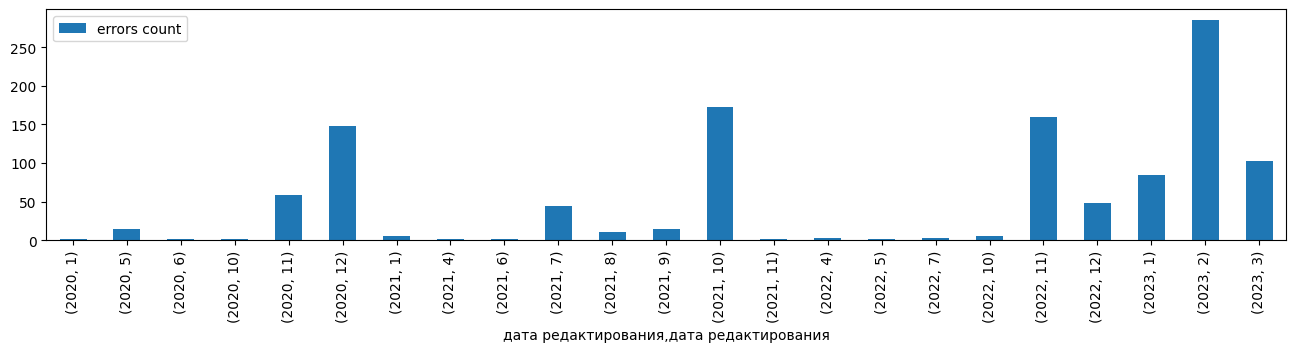

In [57]:
import matplotlib.pyplot as plt


ax = userdocs.groupby(
    [userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month ])[
        ['errors count']].count().plot(kind="bar", figsize=(16,3))

plt.show()

In [58]:

# auto_docs = validate_markup(auto_docs_ids)


# Statistics
### Collecting org types

In [59]:
from collections import Counter
statistics = {}


l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k) for k in l]
c = Counter(l)


statistics['org_types_cased'] = pd.DataFrame(c.items(),  columns = ['type', 'count']).sort_values(['count', 'type'], ascending=False)
statistics['org_types_cased'].to_csv("statistics.org_types_cased.csv")
statistics['org_types_cased']

,type,count
0,Общество с ограниченной ответственностью,1205
3,Акционерное общество,359
1,Публичное акционерное общество,265
2,nan,112
4,ООО,68
...,...,...
37,Акционерного общества,1
62,Администрация муниципального образования,1
14,Автономное учреждение Омской области дополните...,1
28,АО НПО,1


In [60]:
l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)


statistics['org_types'] = pd.DataFrame(c.items(),  columns = ['type', 'count']).sort_values(['count', 'type'], ascending=False)
statistics['org_types'].to_csv("statistics.org_types.csv")
statistics['org_types']

,type,count
0,общество с ограниченной ответственностью,1218
3,акционерное общество,367
1,публичное акционерное общество,280
2,nan,112
4,ооо,68
...,...,...
47,акционерное,1
31,акционерного общества,1
51,администрация муниципального образования,1
12,автономное учреждение омской области дополните...,1


### Aliases

In [61]:
userdocs['subject kind']

5fb3d7a378df3635f5441d8e      Service
5fe4821db770574a005556be         Deal
5fdb2140542ce403c92b4549      Service
5fe4821eb770574a00555724      Service
5fe48222b770574a005557ee      Service
                              ...    
5fc63d611d0a1603c7a0c96f        Loans
5fbf75af5d05d73d0295faaf      Renting
5fbbe46ea2b4551c06107c9a    Insurance
5fbbe46ba2b4551c06107bd3      Service
5ec2b8d9665f7603e03b1245      Renting
Name: subject kind, Length: 1166, dtype: object

In [62]:
def count_alias_pairs(cased:bool):
    _df = pd.DataFrame()
    for i, v in userdocs.iterrows():
        if cased:
            key = ' & '.join(   np.sort( list([ str(v['Псевдоним 1']), str(v['Псевдоним 2'])])) ) 
        else:
            key = ' & '.join(   np.sort( list([ str(v['Псевдоним 1']).lower(), str(v['Псевдоним 2']).lower()])) ) 
        key2 = ' & '.join( [str(v['subject kind']), key ] )
        _df.at[i, 'count'] = key2



    _t = pd.DataFrame(_df['count'].value_counts())
    for i, v in _t.iterrows():
        s, a1, a2 = str(i).split('&')
    #     print(a2)
        _t.at[i, 'alias 1'] = a1
        _t.at[i, 'alias 2'] = a2
        _t.at[i, 'subject'] = s
#     statistics['alias_pairs']=_t
#     statistics['alias_pairs'].to_csv("statistics.alias_pair.csv")
#     _t
    return _t


statistics['alias_pairs']=count_alias_pairs(cased=False)
statistics['alias_pairs'].to_csv("statistics.alias_pair.csv")

statistics['alias_pairs_cased']=count_alias_pairs(cased=True)
statistics['alias_pairs_cased'].to_csv("statistics.alias_pair_cased.csv")

In [63]:
statistics['alias_pairs_cased']

,count,alias 1,alias 2,subject
Service & Заказчик & Исполнитель,351,Заказчик,Исполнитель,Service
Deal & Покупатель & Поставщик,89,Покупатель,Поставщик,Deal
GeneralContract & Заказчик & Подрядчик,69,Заказчик,Подрядчик,GeneralContract
Renting & Арендатор & Арендодатель,69,Арендатор,Арендодатель,Renting
Loans & Заемщик & Займодавец,58,Заемщик,Займодавец,Loans
...,...,...,...,...
Deal & Потребитель & Теплоснабжающая организация,1,Потребитель,Теплоснабжающая организация,Deal
nan & Арендатор & Арендодатель,1,Арендатор,Арендодатель,nan
Service & Вещатель & Оператор связи,1,Вещатель,Оператор связи,Service
nan & Арендатор & Субарендатор,1,Арендатор,Субарендатор,nan


In [64]:
statistics['alias_pairs']

,count,alias 1,alias 2,subject
Service & заказчик & исполнитель,368,заказчик,исполнитель,Service
Deal & покупатель & поставщик,89,покупатель,поставщик,Deal
GeneralContract & заказчик & подрядчик,76,заказчик,подрядчик,GeneralContract
Renting & арендатор & арендодатель,76,арендатор,арендодатель,Renting
Loans & заемщик & займодавец,58,заемщик,займодавец,Loans
...,...,...,...,...
Charity & жертвователь & жертвонол уча гель,1,жертвователь,жертвонол уча гель,Charity
Service & банк & клиент,1,банк,клиент,Service
Service & сторона & сторона,1,сторона,сторона,Service
Service & сторона 1 & сторона 2,1,сторона 1,сторона 2,Service


## Validate auto markup

In [65]:
del userdocs
auto_docs_ids = stats[ (stats.user_correction_date.isnull()) & (stats.source=='db') & (stats['documentType']=='CONTRACT') ].index
errors_report_file_prefix = "ai_markup_errors"
errors_report_metric_prefix = "ai"
user_docs_ids = auto_docs_ids
%run -i -t /root/artem/analyser/trainsets/validate_markup.ipynb
del user_docs_ids

auto_docs = userdocs

DEBUG - 2023-03-06 14:58:36,541 - retrain_ipynb - --=logging started=--


DEBUG - 2023-03-06 14:58:36,541 - retrain_ipynb - --=logging started=--


DEBUG - 2023-03-06 14:58:36,541 - retrain_ipynb - --=logging started=--


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


Running on :platform.processor()='x86_64'
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define
reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports
['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=
Number of contract IDs for validation (set ouside) is 792
CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 23.6 µs
CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 20.3 µs


#### Всего ошибок: 1542.0 в 792 документах -- (1.946969696969697 на документ)

CPU times: user 2.51 s, sys: 136 ms, total: 2.65 s
Wall time: 3.84 s
<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/c87fee6f59c64a4db6cb2ad1fda731a0/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='c87fee6f59c64a4db6cb2ad1fda731a0', run_name='exultant-fox-663', run_uuid='c87fee6f59c64a4db6cb2ad1fda731a0', start_time=1678103916552, status='RUNNING', user_id='root'>


### Invalidate no-date docs

In [66]:
bad_docs = auto_docs[ (auto_docs['Дата'].isnull()) | (auto_docs['errors severity']>=10)]
bad_docs.index

for i, row in stats.iterrows():
    if i in bad_docs.index:
        stats.at[i, 'valid'] = False
# stats.loc[bad_docs.index].valid=False
stats.loc[bad_docs.index].valid
# for i, row in stats.iterrows():
#     if i

Series([], Name: valid, dtype: object)

In [67]:
good_docs = auto_docs[ (~auto_docs['Дата'].isnull()) & (auto_docs['errors severity']<10)]
good_docs
# auto_docs[auto_docs['errors count']<3]

,дата редактирования,link,error,error missing,errors count,errors severity,subject len,subject kind,Форма собственности 1,Наименование 1,...,Псевдоним 2,Дата,сумма,сумма без налога,сумма (старая),currency,subject,Номер,сумма с налогом,налог
63ce4a4be83d1ee490f3f6ea,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,налог не указан;\nНаименование 2: кавычка не з...,,3,9,166.0,Service,Общество с ограниченной ответственностью,Газпромнефть-Каталитические системы,...,Исполнитель,«23» апреля 2021,10,10,10,NaN,1.1. Настоящий Договор регламентирует общие пр...,№ (Лн-ье/сс,NaN,NaN
5fb3d7a478df3635f5441dbd,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\nНаименование 2: кавычка не з...,,3,7,53.0,Service,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,...,Заказчик,«12» августа 2020,том числе НДС 20% -15570.00 (Пятнадцать тысяч ...,NaN,-15570.00,рублей,NaN,№ 40/069-2020,NaN,NaN
5fdb2140542ce403c92b453b,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,налог не указан;\nНаименование 2: кавычка не з...,,3,7,85.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город,...,Заказчик,14 мая 2019,. Общая сумма договора составляет 15000 (Пятна...,NaN,15000,рублей,NaN,№ 19-11Д,NaN,NaN
5fdb2140542ce403c92b454e,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,налог не указан;\nНаименование 2: кавычка не з...,,3,7,86.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город,...,Заказчик,14 мая 2019,. Общая сумма договора составляет 15000 (Пятна...,NaN,15000,рублей,NaN,№ 9-11Д,NaN,NaN
5fb3d4a178df3635f5441c8b,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,Наименование 2: кавычка не закрыта;\nНаименова...,сумма договора отсутсвует;\n,3,7,49.0,Service,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город,...,Заказчик,«30» декабря 2019,NaN,NaN,NaN,NaN,NaN,№ 19-69Д,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fbbad2ca2b4551c06107848,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0,0,45.0,Service,Акционерное общество,Арктика Медиа,...,Исполнитель,«30» Сентября 2020,выплачивает Исполнителю компенсацию в размере ...,NaN,10000,рублей,NaN,№ 20-57Р,NaN,NaN
5fbbbd1ca2b4551c06107a5a,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0,0,86.0,Service,Акционерное общество,Арктика Медиа,...,Исполнитель,«14» сентября 2020,автотранспортных услуг по договору составляет ...,NaN,140400,рублей,NaN,№ 20-47Р,NaN,NaN
5fb674ff33c72547b7550013,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,,0,0,41.0,Service,Акционерное общество,Арктика Медиа,...,Подрядчик,«19» декабря 2019,. Стоимость полиграфической продукции составля...,NaN,"16950,00",рублей,NaN,№ 19-341,NaN,NaN
5fe07edb167d501e4c4e6071,NaN,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0,0,70.0,Charity,Общество с ограниченной ответственностью,Газпромнефть НТЦ,...,Благополучатель,«06» июня 2019,пожертвования денежные средства в сумме 164000...,NaN,1640000,рублей,NaN,НТЦ-19/03000/00930/Р,NaN,NaN


# Make datapoints

In [68]:
work_dir

PosixPath('/root/artem/work')

In [69]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [70]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set




248

In [71]:
# good_docs.index

# intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 

### Trainset fixtures
#### Invalidate long subjects

In [72]:
%%time

ids = list(dups_s.index)



if not 'subject_pos' in stats:
    stats['subject_pos'] = None
        
ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len  
            
            stats.at[_id, 'subject_pos'] = span[0]
            dups_s.at[_id, 'subject_pos'] = span[0]  
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
# stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


CPU times: user 3.62 s, sys: 320 ms, total: 3.94 s
Wall time: 6.68 s


#### Fix missing headers

In [73]:
%%time

from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k, oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


CPU times: user 2.49 s, sys: 381 ms, total: 2.87 s
Wall time: 5.53 s


In [74]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [75]:
len(ids_of_long_subject_docs)

0

In [76]:
dups_s

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subj_len,headers,subject_pos,org-1-type,org-2-type,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-06 14:57:59.719721,5950.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,51.0,14.0,NaN,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,2.011307e-01,-3.676084e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-06 14:58:02.840701,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,106.0,10.0,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.091754e-01,4.114182e+18,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,79.0,4.0,1444.0,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.169281e-01,-2.326586e+18,1.0
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,121.0,11.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,6.763288e-01,-3.199301e+18,4.0
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,81.0,12.0,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,7.102020e-01,-2.951830e+18,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6130d65d4f22ff1b7e02fd06,db,5439d9e2947703f8ddfd8dfcacf70812,2.4.6,2023-03-02 18:17:07.733416,70.0,2021-09-02 16:55:39.995000+00:00,NaN,NaN,NaN,NaN,...,5.0,1.0,4.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6130...,True,7.878661e+07,-8.889024e+17,1.0
6166e28787f1d9065bb8b949,db,2f8ca4051ac3f51a7bf796627406fd4c,2.5.0,2023-03-02 18:17:11.353487,970.0,2021-10-13 16:46:44.849000+00:00,NaN,NaN,NaN,NaN,...,22.0,6.0,27.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/6166...,True,7.878661e+07,1.654519e+18,1.0
63ce4a5ee83d1ee490f3f7ea,db,a4560b85845f310fab3866b5e756e3ee,23.01.23,2023-03-02 18:17:40.779840,90.0,2023-01-23 19:44:53.334000+00:00,NaN,NaN,NaN,рублей,...,9.0,1.0,89.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,7.878661e+07,5.857173e+16,1.0


In [77]:
%%time
stats.to_csv(export_fn, index=True)

CPU times: user 33.3 ms, sys: 7.26 ms, total: 40.5 ms
Wall time: 39.7 ms


# Main sequence

In [78]:
%%time

# raise('test mode!')

# for k, oid in enumerate(list(ids)):
for k, oid in enumerate(list(intersection_set)): #enumerate(ids): 
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


5ec2b8da665f7603e03b125c 0 of 2426 db
2353
fixed number: ['№ 12345/17'] -->  ['12345/17']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b125c-datapoint-embeddings.npy (2353, 1024)
62948fc7df54d406a99b15df 1 of 2426 db
5082
embeddings saved to /root/artem/work/datasets/62948fc7df54d406a99b15df-datapoint-embeddings.npy (5082, 1024)
6380857d6a07f3e980b2c332 2 of 2426 db
3054


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


embeddings saved to /root/artem/work/datasets/6380857d6a07f3e980b2c332-datapoint-embeddings.npy (3054, 1024)
5fe48219b770574a00555601 3 of 2426 db
1840
fixed number: ['№ 235/20р'] -->  ['235/20р']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a00555601-datapoint-embeddings.npy (1840, 1024)
5fca2ab09083b679224c7622 4 of 2426 db
2971


fixed number: ['№ WAH50630_73273_41030'] -->  ['WAH50630_73273_41030']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7622-datapoint-embeddings.npy (2971, 1024)
5fe48220b770574a00555782 5 of 2426 db
2460
fixed number: ['№ 12/09-2020'] -->  ['12/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555782-datapoint-embeddings.npy (2460, 1024)
638085ad6a07f3e980b2c742 6 of 2426 db
1784
fixed number: ['№ 361'] -->  ['361']
embeddings saved to /root/artem/work/datasets/638085ad6a07f3e980b2c742-datapoint-embeddings.npy (1784, 1024)
5fbbe46da2b4551c06107c78 7 of 2426 db
6018


fixed number: ['№ 0952402664'] -->  ['0952402664']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c78-datapoint-embeddings.npy (6018, 1024)
5fbbe46da2b4551c06107c80 8 of 2426 db
2289
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c80-datapoint-embeddings.npy (2289, 1024)
5fdb213d542ce403c92b451c 9 of 2426 db
1990


embeddings saved to /root/artem/work/datasets/5fdb213d542ce403c92b451c-datapoint-embeddings.npy (1990, 1024)
5fe34f63b770574a005553c3 10 of 2426 db
1243
fixed number: ['№ ЛС/19/103'] -->  ['ЛС/19/103']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c3-datapoint-embeddings.npy (1243, 1024)
6152e3af8558145da68d8790 11 of 2426 db
6840
embeddings saved to /root/artem/work/datasets/6152e3af8558145da68d8790-datapoint-embeddings.npy (6840, 1024)


5fe4821eb770574a00555704 12 of 2426 db
1895
fixed number: ['№ 103/09-2019'] -->  ['103/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555704-datapoint-embeddings.npy (1895, 1024)
5fb27c63d8c9df1ed1236f3f 13 of 2426 db
6033


embeddings saved to /root/artem/work/datasets/5fb27c63d8c9df1ed1236f3f-datapoint-embeddings.npy (6033, 1024)
5fc7a031c54bc33809e2617f 14 of 2426 db
1574
embeddings saved to /root/artem/work/datasets/5fc7a031c54bc33809e2617f-datapoint-embeddings.npy (1574, 1024)
63ce4b16e83d1ee490f4016a 15 of 2426 db
2331
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f4016a-datapoint-embeddings.npy (2331, 1024)
5fe34f63b770574a005553ca 16 of 2426 db
2825


fixed number: ['№ н-1/2019-Ю'] -->  ['н-1/2019-Ю']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553ca-datapoint-embeddings.npy (2825, 1024)
5fb3d7a078df3635f5441d42 17 of 2426 db
1150
embeddings saved to /root/artem/work/datasets/5fb3d7a078df3635f5441d42-datapoint-embeddings.npy (1150, 1024)
638085a16a07f3e980b2c5f0 18 of 2426 db
1831
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085a16a07f3e980b2c5f0-datapoint-embeddings.npy (1831, 1024)
5fe4821ab770574a00555618 19 of 2426 db
1637
fixed number: ['№ 25/09-2020'] -->  ['25/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555618-datapoint-embeddings.npy (1637, 1024)
60002adfb08473039387bcd3 20 of 2426 db
1695


fixed number: ['№ 1598-8745-963'] -->  ['1598-8745-963']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcd3-datapoint-embeddings.npy (1695, 1024)
5ec2b8da665f7603e03b1252 21 of 2426 db
1914
fixed number: ['№ 4'] -->  ['4']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1252-datapoint-embeddings.npy (1914, 1024)
5feb3e50bd24992aa3104103 22 of 2426 db
2779
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa3104103-datapoint-embeddings.npy (2779, 1024)


63c506d2e2456d59975e1346 23 of 2426 db
8751


embeddings saved to /root/artem/work/datasets/63c506d2e2456d59975e1346-datapoint-embeddings.npy (8751, 1024)
5fb3d4a178df3635f5441c70 24 of 2426 db
3953
embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c70-datapoint-embeddings.npy (3953, 1024)
5fbbe466a2b4551c06107adc 25 of 2426 db
2246


fixed number: ['№ 09-05Д'] -->  ['09-05Д']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107adc-datapoint-embeddings.npy (2246, 1024)
5fbbe46da2b4551c06107c4d 26 of 2426 db
3058
fixed number: ['№ 20-06Д'] -->  ['20-06Д']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c4d-datapoint-embeddings.npy (3058, 1024)
5fb3d79f78df3635f5441d3a 27 of 2426 db
1574
embeddings saved to /root/artem/work/datasets/5fb3d79f78df3635f5441d3a-datapoint-embeddings.npy (1574, 1024)
5fdb2142542ce403c92b4582 28 of 2426 db
2952


embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b4582-datapoint-embeddings.npy (2952, 1024)
6380859e6a07f3e980b2c5c0 29 of 2426 db
2072
fixed number: ['№ 010-0079379-408-2021'] -->  ['010-0079379-408-2021']
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5c0-datapoint-embeddings.npy (2072, 1024)
5fbbe46aa2b4551c06107bc6 30 of 2426 db
5311


embeddings saved to /root/artem/work/datasets/5fbbe46aa2b4551c06107bc6-datapoint-embeddings.npy (5311, 1024)
5fe48222b770574a0055580f 31 of 2426 db
4719


fixed number: ['№ 19/09000/01027/Р/14'] -->  ['19/09000/01027/Р/14']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a0055580f-datapoint-embeddings.npy (4719, 1024)
63c506cde2456d59975e12e6 32 of 2426 db
581
embeddings saved to /root/artem/work/datasets/63c506cde2456d59975e12e6-datapoint-embeddings.npy (581, 1024)
5fdb2143542ce403c92b45af 33 of 2426 db
3686
embeddings saved to /root/artem/work/datasets/5fdb2143542ce403c92b45af-datapoint-embeddings.npy (3686, 1024)
5fca2ab09083b679224c7624 34 of 2426 db
2506
fixed number: ['№ 19/20000/00100/Р'] -->  ['19/20000/00100/Р']
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7624-datapoint-embeddings.npy (2506, 1024)
638085706a07f3e980b2c1ed 35 of 2426 db
3478
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085706a07f3e980b2c1ed-datapoint-embeddings.npy (3478, 1024)
5fe48217b770574a0055557d 36 of 2426 db
351


fixed number: ['№ 19-11Д'] -->  ['19-11Д']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055557d-datapoint-embeddings.npy (351, 1024)
5fe48220b770574a00555781 37 of 2426 db
2251
fixed number: ['№ .УПС/20-Н'] -->  ['.УПС/20-Н']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555781-datapoint-embeddings.npy (2251, 1024)
5fe4821fb770574a00555755 38 of 2426 db
1891
fixed number: ['№ 19-51Р'] -->  ['19-51Р']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555755-datapoint-embeddings.npy (1891, 1024)
6380859e6a07f3e980b2c5c4 39 of 2426 db
4183
fixed number: ['№ 010-0074375-408-2021'] -->  ['010-0074375-408-2021']
embeddings saved to /root/artem/work/datasets/6380859e6a07f3e980b2c5c4-datapoint-embeddings.npy (4183, 1024)
62dfbce15d5a202ba67b842d 40 of 2426 db
5556
fixed number: ['№ 1234'] -->  ['1234']


embeddings saved to /root/artem/work/datasets/62dfbce15d5a202ba67b842d-datapoint-embeddings.npy (5556, 1024)
5fe48222b770574a005557e7 41 of 2426 db
3336
fixed number: ['№ 20-03/253'] -->  ['20-03/253']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557e7-datapoint-embeddings.npy (3336, 1024)
5fe4821ab770574a00555638 42 of 2426 db
5389
fixed number: ['№ 60-2020'] -->  ['60-2020']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555638-datapoint-embeddings.npy (5389, 1024)
5fe48219b770574a005555ed 43 of 2426 db
5007
fixed number: ['№ НБ 20190124004'] -->  ['НБ 20190124004']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555ed-datapoint-embeddings.npy (5007, 1024)
5fe4821eb770574a00555718 44 of 2426 db
2596


fixed number: ['№ 35/09-2020'] -->  ['35/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555718-datapoint-embeddings.npy (2596, 1024)
638f0a88b1363747e929f359 45 of 2426 db
2971
embeddings saved to /root/artem/work/datasets/638f0a88b1363747e929f359-datapoint-embeddings.npy (2971, 1024)
5fe4821eb770574a00555724 46 of 2426 db
1983
fixed number: ['№ 29/09-2020'] -->  ['29/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555724-datapoint-embeddings.npy (1983, 1024)
5fe4821ab770574a00555657 47 of 2426 db
1640
fixed number: ['№ 17/09-2019'] -->  ['17/09-2019']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555657-datapoint-embeddings.npy (1640, 1024)
5fe4821db770574a005556be 48 of 2426 db
3552
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556be-datapoint-embeddings.npy (3552, 1024)
63a430a6beaa9eeec65ecb0b 49 of 2426 db
1362
embeddings saved to /root/artem/work/datasets/63a430a6beaa9eeec65ecb0b-datapoint-e

5fbf75af5d05d73d0295fa89 50 of 2426 db


24703
fixed number: ['№ ГНЗ-19/11029/00043/Р-05'] -->  ['ГНЗ-19/11029/00043/Р-05']
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa89-datapoint-embeddings.npy (24703, 1024)
62cd547a32fe0e1ffcc28116 51 of 2426 db


3098
embeddings saved to /root/artem/work/datasets/62cd547a32fe0e1ffcc28116-datapoint-embeddings.npy (3098, 1024)
5fb3d7a378df3635f5441d8e 52 of 2426 db
2694
embeddings saved to /root/artem/work/datasets/5fb3d7a378df3635f5441d8e-datapoint-embeddings.npy (2694, 1024)
63c506e5e2456d59975e155d 53 of 2426 db
11653


embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e155d-datapoint-embeddings.npy (11653, 1024)
5fe48218b770574a005555c6 54 of 2426 db
2043
fixed number: ['№ 17/09-2020'] -->  ['17/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c6-datapoint-embeddings.npy (2043, 1024)
63c506e5e2456d59975e156b 55 of 2426 db
1523
embeddings saved to /root/artem/work/datasets/63c506e5e2456d59975e156b-datapoint-embeddings.npy (1523, 1024)
63a43092beaa9eeec65ecb09 56 of 2426 db
3139
embeddings saved to /root/artem/work/datasets/63a43092beaa9eeec65ecb09-datapoint-embeddings.npy (3139, 1024)
5fbbe46ca2b4551c06107c12 57 of 2426 db
2115
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c12-datapoint-embeddings.npy (2115, 1024)
5fca2aac9083b679224c75fe 58 of 2426 db
1415
embeddings saved to /root/artem/work/datasets/5fca2aac9083b679224c75fe-datapoint-embeddings.npy (1415, 1024)
611f87d5ddbe0a842820e64e 59 of 2426 db
488
embeddings saved to /root/artem

embeddings saved to /root/artem/work/datasets/63c506b4e2456d59975e1041-datapoint-embeddings.npy (3165, 1024)
5fe4821fb770574a0055574b 61 of 2426 db
2291
fixed number: ['№ 203/20р'] -->  ['203/20р']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a0055574b-datapoint-embeddings.npy (2291, 1024)
617269de8fd5658689eb2bca 62 of 2426 db
4348
embeddings saved to /root/artem/work/datasets/617269de8fd5658689eb2bca-datapoint-embeddings.npy (4348, 1024)
5fbbbd14a2b4551c061078e1 63 of 2426 db
3401
fixed number: ['№ Тг 000391578'] -->  ['Тг 000391578']
embeddings saved to /root/artem/work/datasets/5fbbbd14a2b4551c061078e1-datapoint-embeddings.npy (3401, 1024)
6128931bb8ceba5a6803d26a 64 of 2426 db
493
fixed number: ['№ 8'] -->  ['8']
embeddings saved to /root/artem/work/datasets/6128931bb8ceba5a6803d26a-datapoint-embeddings.npy (493, 1024)
60002adfb08473039387bcd6 65 of 2426 db
3170


fixed number: ['№ 159-951-951-А'] -->  ['159-951-951-А']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcd6-datapoint-embeddings.npy (3170, 1024)
61289013b8ceba5a6803d266 66 of 2426 db
493
fixed number: ['№ 8'] -->  ['8']
embeddings saved to /root/artem/work/datasets/61289013b8ceba5a6803d266-datapoint-embeddings.npy (493, 1024)
5fe4821db770574a005556c6 67 of 2426 db
2813
fixed number: ['№ 34/09-2020'] -->  ['34/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556c6-datapoint-embeddings.npy (2813, 1024)
6391b4771864c6df4d29f332 68 of 2426 db
1990
embeddings saved to /root/artem/work/datasets/6391b4771864c6df4d29f332-datapoint-embeddings.npy (1990, 1024)
63c506b8e2456d59975e109c 69 of 2426 db
1137
fixed number: ['___________________'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506b8e2456d59975e109c-datapoint-embeddings.npy (1137, 1024)
5fe48218b770574a005555d3 70 of 2426 db
2384
fixed number: ['№ 03/09-2020'] -->  ['03/09-2020

14955
fixed number: ['№ 05092022'] -->  ['05092022']
embeddings saved to /root/artem/work/datasets/6391a4451002115a6029f38b-datapoint-embeddings.npy (14955, 1024)
5fe4821ab770574a00555634 72 of 2426 db
2297
fixed number: ['№ ННГ-19/09000/01759/Р'] -->  ['ННГ-19/09000/01759/Р']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555634-datapoint-embeddings.npy (2297, 1024)
63c506cae2456d59975e1284 73 of 2426 db
4161


embeddings saved to /root/artem/work/datasets/63c506cae2456d59975e1284-datapoint-embeddings.npy (4161, 1024)
5ec2b8db665f7603e03b1281 74 of 2426 db
12872


fixed number: ['№ 30912'] -->  ['30912']
embeddings saved to /root/artem/work/datasets/5ec2b8db665f7603e03b1281-datapoint-embeddings.npy (12872, 1024)
63c506e0e2456d59975e14e2 75 of 2426 db
3679
fixed number: ['_____________'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506e0e2456d59975e14e2-datapoint-embeddings.npy (3679, 1024)
63ce4af6e83d1ee490f3ff45 76 of 2426 db
11743


embeddings saved to /root/artem/work/datasets/63ce4af6e83d1ee490f3ff45-datapoint-embeddings.npy (11743, 1024)
635fa41bbf4cb23cbb3927e5 77 of 2426 db
7713
embeddings saved to /root/artem/work/datasets/635fa41bbf4cb23cbb3927e5-datapoint-embeddings.npy (7713, 1024)
6343cbdd172785f510f15df3 78 of 2426 db
332
fixed number: ['№ ППН-11/12100/02212/2012/15-ПН-НП'] -->  ['ППН-11/12100/02212/2012/15-ПН-НП']
embeddings saved to /root/artem/work/datasets/6343cbdd172785f510f15df3-datapoint-embeddings.npy (332, 1024)
63908ca4a1bded13e629f2e9 79 of 2426 db
3139
fixed number: ['№ 110801/20'] -->  ['110801/20']
embeddings saved to /root/artem/work/datasets/63908ca4a1bded13e629f2e9-datapoint-embeddings.npy (3139, 1024)
5fbbbd19a2b4551c061079c5 80 of 2426 db
1321
embeddings saved to /root/artem/work/datasets/5fbbbd19a2b4551c061079c5-datapoint-embeddings.npy (1321, 1024)


5fbf75af5d05d73d0295fa88 81 of 2426 db


28208


embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa88-datapoint-embeddings.npy (28208, 1024)
5fb3d49f78df3635f5441bee 82 of 2426 db
1036
fixed number: ['№ 20-02Р'] -->  ['20-02Р']
embeddings saved to /root/artem/work/datasets/5fb3d49f78df3635f5441bee-datapoint-embeddings.npy (1036, 1024)
5fb3d4a278df3635f5441ca6 83 of 2426 db
12217


fixed number: ['№ 2920 LM 0066'] -->  ['2920 LM 0066']
embeddings saved to /root/artem/work/datasets/5fb3d4a278df3635f5441ca6-datapoint-embeddings.npy (12217, 1024)
5fe48219b770574a005555e6 84 of 2426 db
1712
fixed number: ['№ 19-52Р'] -->  ['19-52Р']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555e6-datapoint-embeddings.npy (1712, 1024)
5fe07edd167d501e4c4e6090 85 of 2426 db
9047
fixed number: ['№ НТЦ-20/04500/00200/Д'] -->  ['НТЦ-20/04500/00200/Д']
embeddings saved to /root/artem/work/datasets/5fe07edd167d501e4c4e6090-datapoint-embeddings.npy (9047, 1024)
5fb27c62d8c9df1ed1236f02 86 of 2426 db
1985


fixed number: ['№ 19-11Д'] -->  ['19-11Д']
embeddings saved to /root/artem/work/datasets/5fb27c62d8c9df1ed1236f02-datapoint-embeddings.npy (1985, 1024)
5ec2b8d8665f7603e03b1224 87 of 2426 db
1876
fixed number: ['№ 7583-ЗР'] -->  ['7583-ЗР']
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1224-datapoint-embeddings.npy (1876, 1024)
5fe07edb167d501e4c4e606b 88 of 2426 db
402
embeddings saved to /root/artem/work/datasets/5fe07edb167d501e4c4e606b-datapoint-embeddings.npy (402, 1024)
63c506c7e2456d59975e1232 89 of 2426 db
5222
fixed number: ['___'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506c7e2456d59975e1232-datapoint-embeddings.npy (5222, 1024)
6380858b6a07f3e980b2c4c5 90 of 2426 db
5409
embeddings saved to /root/artem/work/datasets/6380858b6a07f3e980b2c4c5-datapoint-embeddings.npy (5409, 1024)


5fe4821bb770574a0055565a 91 of 2426 db
1523
fixed number: ['№ 63'] -->  ['63']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565a-datapoint-embeddings.npy (1523, 1024)
638085766a07f3e980b2c275 92 of 2426 db
3885
embeddings saved to /root/artem/work/datasets/638085766a07f3e980b2c275-datapoint-embeddings.npy (3885, 1024)
5fe48222b770574a005557ee 93 of 2426 db
5866
fixed number: ['№ ГНР-20/09000/00137/Р/14'] -->  ['ГНР-20/09000/00137/Р/14']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a005557ee-datapoint-embeddings.npy (5866, 1024)
5fb3d7a278df3635f5441d7b 94 of 2426 db
4823


fixed number: ['№ ГНР-19/00000/00919/Р/15'] -->  ['ГНР-19/00000/00919/Р/15']
embeddings saved to /root/artem/work/datasets/5fb3d7a278df3635f5441d7b-datapoint-embeddings.npy (4823, 1024)
5fca2aad9083b679224c7609 95 of 2426 db
2672
fixed number: ['№ н-1/2019'] -->  ['н-1/2019']
embeddings saved to /root/artem/work/datasets/5fca2aad9083b679224c7609-datapoint-embeddings.npy (2672, 1024)
5fe48219b770574a005555fe 96 of 2426 db
1731
fixed number: ['№ 19-46Р'] -->  ['19-46Р']
embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555fe-datapoint-embeddings.npy (1731, 1024)
63c506e1e2456d59975e14e4 97 of 2426 db
3687
embeddings saved to /root/artem/work/datasets/63c506e1e2456d59975e14e4-datapoint-embeddings.npy (3687, 1024)
638f0a81b1363747e929f304 98 of 2426 db


17866
embeddings saved to /root/artem/work/datasets/638f0a81b1363747e929f304-datapoint-embeddings.npy (17866, 1024)
62bdad696e75fae95cce25eb 99 of 2426 db
1469
fixed number: ['№ 112/ЗТП/УРЛ-2021'] -->  ['112/ЗТП/УРЛ-2021']
embeddings saved to /root/artem/work/datasets/62bdad696e75fae95cce25eb-datapoint-embeddings.npy (1469, 1024)
5fb3d7a978df3635f5441ebb 100 of 2426 db
4910


embeddings saved to /root/artem/work/datasets/5fb3d7a978df3635f5441ebb-datapoint-embeddings.npy (4910, 1024)
63c506c8e2456d59975e125c 101 of 2426 db
1744
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e125c-datapoint-embeddings.npy (1744, 1024)
5fbbe466a2b4551c06107ad6 102 of 2426 db
1965
fixed number: ['№ 19-02Д'] -->  ['19-02Д']
embeddings saved to /root/artem/work/datasets/5fbbe466a2b4551c06107ad6-datapoint-embeddings.npy (1965, 1024)
635fa422bf4cb23cbb392838 103 of 2426 db
7136
embeddings saved to /root/artem/work/datasets/635fa422bf4cb23cbb392838-datapoint-embeddings.npy (7136, 1024)
5fe48220b770574a00555790 104 of 2426 db
5364


fixed number: ['№ 38/09-2020'] -->  ['38/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a00555790-datapoint-embeddings.npy (5364, 1024)
5fe34f63b770574a005553cf 105 of 2426 db
1482
fixed number: ['№ 19-45Р'] -->  ['19-45Р']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553cf-datapoint-embeddings.npy (1482, 1024)
5fe4821bb770574a00555678 106 of 2426 db
1464
fixed number: ['№ 63'] -->  ['63']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555678-datapoint-embeddings.npy (1464, 1024)
5fdb2140542ce403c92b4549 107 of 2426 db
4025
fixed number: ['№ 19-36Д'] -->  ['19-36Д']
embeddings saved to /root/artem/work/datasets/5fdb2140542ce403c92b4549-datapoint-embeddings.npy (4025, 1024)
5fdb2142542ce403c92b459e 108 of 2426 db
3638
embeddings saved to /root/artem/work/datasets/5fdb2142542ce403c92b459e-datapoint-embeddings.npy (3638, 1024)
5fe4821eb770574a005556f5 109 of 2426 db
2350


fixed number: ['№ 93557/11-19'] -->  ['93557/11-19']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556f5-datapoint-embeddings.npy (2350, 1024)
63ce4b16e83d1ee490f4014d 110 of 2426 db
5917
embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f4014d-datapoint-embeddings.npy (5917, 1024)
63c506bde2456d59975e111e 111 of 2426 db
6281
embeddings saved to /root/artem/work/datasets/63c506bde2456d59975e111e-datapoint-embeddings.npy (6281, 1024)
5ec2b8da665f7603e03b126a 112 of 2426 db
3763


fixed number: ['№ 1111/222'] -->  ['1111/222']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b126a-datapoint-embeddings.npy (3763, 1024)
5fdb2141542ce403c92b4576 113 of 2426 db
2330
fixed number: ['№ 19-56Д'] -->  ['19-56Д']
embeddings saved to /root/artem/work/datasets/5fdb2141542ce403c92b4576-datapoint-embeddings.npy (2330, 1024)
5fbbe468a2b4551c06107b52 114 of 2426 db
3975
embeddings saved to /root/artem/work/datasets/5fbbe468a2b4551c06107b52-datapoint-embeddings.npy (3975, 1024)
5fe4821ab770574a00555656 115 of 2426 db
1544
fixed number: ['№ 8-ТЭ'] -->  ['8-ТЭ']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555656-datapoint-embeddings.npy (1544, 1024)
5ec2b8d9665f7603e03b1241 116 of 2426 db
2647
fixed number: ['№ 965/03'] -->  ['965/03']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1241-datapoint-embeddings.npy (2647, 1024)
5fbbe467a2b4551c06107afb 117 of 2426 db
1788


fixed number: ['№ 1496'] -->  ['1496']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107afb-datapoint-embeddings.npy (1788, 1024)
5fb6751033c72547b755016d 118 of 2426 db
11732


embeddings saved to /root/artem/work/datasets/5fb6751033c72547b755016d-datapoint-embeddings.npy (11732, 1024)
63c506dbe2456d59975e143d 119 of 2426 db
3489
embeddings saved to /root/artem/work/datasets/63c506dbe2456d59975e143d-datapoint-embeddings.npy (3489, 1024)
5feb3e50bd24992aa31040e5 120 of 2426 db
1812
fixed number: ['№ 159/5478/2655-СН'] -->  ['159/5478/2655-СН']
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa31040e5-datapoint-embeddings.npy (1812, 1024)
5fe48221b770574a005557da 121 of 2426 db
4877
fixed number: ['№ 19/09000/01026/Р/14'] -->  ['19/09000/01026/Р/14']
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557da-datapoint-embeddings.npy (4877, 1024)
5fc635251d0a1603c7a0c93c 122 of 2426 db
3267


embeddings saved to /root/artem/work/datasets/5fc635251d0a1603c7a0c93c-datapoint-embeddings.npy (3267, 1024)
637395f0f3d1fa3e3137543a 123 of 2426 db
1982
fixed number: ['№ УЦ 234-4Р-20'] -->  ['УЦ 234-4Р-20']
embeddings saved to /root/artem/work/datasets/637395f0f3d1fa3e3137543a-datapoint-embeddings.npy (1982, 1024)
63c506c2e2456d59975e11a8 124 of 2426 db
2172
embeddings saved to /root/artem/work/datasets/63c506c2e2456d59975e11a8-datapoint-embeddings.npy (2172, 1024)
5fe4821ab770574a00555632 125 of 2426 db
2108
fixed number: ['№ 19-47Р'] -->  ['19-47Р']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555632-datapoint-embeddings.npy (2108, 1024)
63ac1fa9862ea92bf713c50a 126 of 2426 db
2782
fixed number: ['№ н-1/2017-Ю'] -->  ['н-1/2017-Ю']
embeddings saved to /root/artem/work/datasets/63ac1fa9862ea92bf713c50a-datapoint-embeddings.npy (2782, 1024)
5fb3b97e00881c332b56729f 127 of 2426 db
4810


fixed number: ['№ S СРК 2n/rr^rryCcA3</P'] -->  ['S СРК 2n/rr^rryCcA3</P']
embeddings saved to /root/artem/work/datasets/5fb3b97e00881c332b56729f-datapoint-embeddings.npy (4810, 1024)
5fe4821eb770574a005556fe 128 of 2426 db
1230
fixed number: ['№ 7'] -->  ['7']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556fe-datapoint-embeddings.npy (1230, 1024)
6166e28787f1d9065bb8b943 129 of 2426 db
5992
embeddings saved to /root/artem/work/datasets/6166e28787f1d9065bb8b943-datapoint-embeddings.npy (5992, 1024)
63c506dde2456d59975e1469 130 of 2426 db
1953
embeddings saved to /root/artem/work/datasets/63c506dde2456d59975e1469-datapoint-embeddings.npy (1953, 1024)
6380855d6a07f3e980b2c073 131 of 2426 db
4600
fixed number: ['№ БС-03'] -->  ['БС-03']


embeddings saved to /root/artem/work/datasets/6380855d6a07f3e980b2c073-datapoint-embeddings.npy (4600, 1024)
5ec2b8da665f7603e03b127e 132 of 2426 db
4766
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b127e-datapoint-embeddings.npy (4766, 1024)
62c54895e599c73b751b7974 133 of 2426 db
1953
fixed number: ['№ 4'] -->  ['4']
embeddings saved to /root/artem/work/datasets/62c54895e599c73b751b7974-datapoint-embeddings.npy (1953, 1024)
5fe48217b770574a00555585 134 of 2426 db
2457
fixed number: ['№ 07/09-2020'] -->  ['07/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a00555585-datapoint-embeddings.npy (2457, 1024)
5fe34f64b770574a005553e3 135 of 2426 db
3948
fixed number: ['№ 20/09000/011943/Д'] -->  ['20/09000/011943/Д']
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e3-datapoint-embeddings.npy (3948, 1024)
5ec2b8d8665f7603e03b1228 136 of 2426 db
1003


fixed number: ['N 167/ЗП'] -->  ['167/ЗП']
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b1228-datapoint-embeddings.npy (1003, 1024)
5fbbe46ca2b4551c06107c15 137 of 2426 db
2601
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c15-datapoint-embeddings.npy (2601, 1024)
63d24bf33554f2343d832c9d 138 of 2426 db
1014
embeddings saved to /root/artem/work/datasets/63d24bf33554f2343d832c9d-datapoint-embeddings.npy (1014, 1024)
5fe4821eb770574a005556fd 139 of 2426 db
2479
fixed number: ['№ 93607/12-19'] -->  ['93607/12-19']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556fd-datapoint-embeddings.npy (2479, 1024)
5fb3d4a078df3635f5441c6d 140 of 2426 db
4953
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c6d-datapoint-embeddings.npy (4953, 1024)
615ac8b28f3b0514f3f423f2 141 of 2426 db
961
embeddings saved to /root/artem/work/datasets/615ac8b28f3b0514f3f423f2-datapoint-embeddings.npy (961, 1024)
63468d42172785f510f15e21 14

embeddings saved to /root/artem/work/datasets/63468d42172785f510f15e21-datapoint-embeddings.npy (2216, 1024)
638085756a07f3e980b2c266 143 of 2426 db
5071
embeddings saved to /root/artem/work/datasets/638085756a07f3e980b2c266-datapoint-embeddings.npy (5071, 1024)
5fe34f64b770574a005553e6 144 of 2426 db
3798
fixed number: ['№ 20/28000/00741/Д'] -->  ['20/28000/00741/Д']
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e6-datapoint-embeddings.npy (3798, 1024)
6380855c6a07f3e980b2c061 145 of 2426 db
1953
embeddings saved to /root/artem/work/datasets/6380855c6a07f3e980b2c061-datapoint-embeddings.npy (1953, 1024)
5fb3d4a178df3635f5441c6f 146 of 2426 db
2456


embeddings saved to /root/artem/work/datasets/5fb3d4a178df3635f5441c6f-datapoint-embeddings.npy (2456, 1024)
5fe4821eb770574a00555708 147 of 2426 db
1515
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a00555708-datapoint-embeddings.npy (1515, 1024)
60002adfb08473039387bcb0 148 of 2426 db
1493
fixed number: ['№ 958-985-658-7'] -->  ['958-985-658-7']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcb0-datapoint-embeddings.npy (1493, 1024)
638085826a07f3e980b2c3b8 149 of 2426 db
2342
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/638085826a07f3e980b2c3b8-datapoint-embeddings.npy (2342, 1024)
63a4306dbeaa9eeec65ecafe 150 of 2426 db


13410
embeddings saved to /root/artem/work/datasets/63a4306dbeaa9eeec65ecafe-datapoint-embeddings.npy (13410, 1024)
5fca2ad69083b679224c7811 151 of 2426 db
4460
fixed number: ['№ б/н'] -->  ['б/н']
embeddings saved to /root/artem/work/datasets/5fca2ad69083b679224c7811-datapoint-embeddings.npy (4460, 1024)
5ec2b8d8665f7603e03b121c 152 of 2426 db
810
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b121c-datapoint-embeddings.npy (810, 1024)
63ce4b16e83d1ee490f40161 153 of 2426 db
1245


embeddings saved to /root/artem/work/datasets/63ce4b16e83d1ee490f40161-datapoint-embeddings.npy (1245, 1024)
638085996a07f3e980b2c585 154 of 2426 db
3028
embeddings saved to /root/artem/work/datasets/638085996a07f3e980b2c585-datapoint-embeddings.npy (3028, 1024)
5ec2b8da665f7603e03b1264 155 of 2426 db
2476
fixed number: ['№ 5'] -->  ['5']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1264-datapoint-embeddings.npy (2476, 1024)
60ed762acddbb3c487368c4d 156 of 2426 db
6056
fixed number: ['№ ГПН / /67/'] -->  ['ГПН / /67/']
embeddings saved to /root/artem/work/datasets/60ed762acddbb3c487368c4d-datapoint-embeddings.npy (6056, 1024)
5fe34f63b770574a005553d2 157 of 2426 db
2673


fixed number: ['№ н-1/2019'] -->  ['н-1/2019']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553d2-datapoint-embeddings.npy (2673, 1024)
5fb3d79e78df3635f5441d1e 158 of 2426 db
1498
fixed number: ['№ 19-45Р'] -->  ['19-45Р']
embeddings saved to /root/artem/work/datasets/5fb3d79e78df3635f5441d1e-datapoint-embeddings.npy (1498, 1024)
63c506b8e2456d59975e109e 159 of 2426 db


14348
fixed number: ['________'] -->  ['']
embeddings saved to /root/artem/work/datasets/63c506b8e2456d59975e109e-datapoint-embeddings.npy (14348, 1024)
63761b03a4c19fe48237543a 160 of 2426 db


12298
embeddings saved to /root/artem/work/datasets/63761b03a4c19fe48237543a-datapoint-embeddings.npy (12298, 1024)
5fbbe46ba2b4551c06107bda 161 of 2426 db
3506
fixed number: ['№ 611/20'] -->  ['611/20']
embeddings saved to /root/artem/work/datasets/5fbbe46ba2b4551c06107bda-datapoint-embeddings.npy (3506, 1024)
6285f525f098f73e14297f93 162 of 2426 db
1738
fixed number: ['№ 36/09-2020'] -->  ['36/09-2020']
embeddings saved to /root/artem/work/datasets/6285f525f098f73e14297f93-datapoint-embeddings.npy (1738, 1024)
62838b2e4d1bfe5e5b297ddb 163 of 2426 db


25014
fixed number: ['№ 9876'] -->  ['9876']


embeddings saved to /root/artem/work/datasets/62838b2e4d1bfe5e5b297ddb-datapoint-embeddings.npy (25014, 1024)
5ec2b8da665f7603e03b1278 164 of 2426 db
5235
fixed number: ['№ 123456'] -->  ['123456']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1278-datapoint-embeddings.npy (5235, 1024)
638085a36a07f3e980b2c61c 165 of 2426 db
1995
embeddings saved to /root/artem/work/datasets/638085a36a07f3e980b2c61c-datapoint-embeddings.npy (1995, 1024)
5fe4821eb770574a0055570f 166 of 2426 db
5571
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a0055570f-datapoint-embeddings.npy (5571, 1024)
63ce4b18e83d1ee490f4017c 167 of 2426 db
5716


fixed number: ['№ ГПНЖС/^/000'] -->  ['ГПНЖС/^/000']
embeddings saved to /root/artem/work/datasets/63ce4b18e83d1ee490f4017c-datapoint-embeddings.npy (5716, 1024)
5fbbe467a2b4551c06107afc 168 of 2426 db
1145
fixed number: ['№ 19-29Д'] -->  ['19-29Д']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107afc-datapoint-embeddings.npy (1145, 1024)
5fb3d7a678df3635f5441e39 169 of 2426 db
3383
fixed number: ['№ 20-03/088'] -->  ['20-03/088']
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e39-datapoint-embeddings.npy (3383, 1024)
5feb3e50bd24992aa31040e2 170 of 2426 db
1169
embeddings saved to /root/artem/work/datasets/5feb3e50bd24992aa31040e2-datapoint-embeddings.npy (1169, 1024)
639083607fc8981f6e29f2de 171 of 2426 db
2869
embeddings saved to /root/artem/work/datasets/639083607fc8981f6e29f2de-datapoint-embeddings.npy (2869, 1024)
5fe4821bb770574a00555673 172 of 2426 db
1672
fixed number: ['№ 19-58Р'] -->  ['19-58Р']
embeddings saved to /root/artem/work/datas

12302
embeddings saved to /root/artem/work/datasets/63761b05a4c19fe482375449-datapoint-embeddings.npy (12302, 1024)
5fe4821bb770574a0055567a 174 of 2426 db
2049
fixed number: ['№ ННГ-19/09000/01373'] -->  ['ННГ-19/09000/01373']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055567a-datapoint-embeddings.npy (2049, 1024)
5fb6750833c72547b75500d1 175 of 2426 db
3971
embeddings saved to /root/artem/work/datasets/5fb6750833c72547b75500d1-datapoint-embeddings.npy (3971, 1024)
5fe4821fb770574a0055572e 176 of 2426 db
990


fixed number: ['№ 32-2020'] -->  ['32-2020']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a0055572e-datapoint-embeddings.npy (990, 1024)
5fb376e2d8c9df1ed123726a 177 of 2426 db
763
fixed number: ['№ 10/19'] -->  ['10/19']
embeddings saved to /root/artem/work/datasets/5fb376e2d8c9df1ed123726a-datapoint-embeddings.npy (763, 1024)
5fe4821eb770574a005556f6 178 of 2426 db
3362
fixed number: ['№ 20-03/088'] -->  ['20-03/088']
embeddings saved to /root/artem/work/datasets/5fe4821eb770574a005556f6-datapoint-embeddings.npy (3362, 1024)
5fe4821db770574a005556dd 179 of 2426 db
3733
fixed number: ['№ 22/09-20'] -->  ['22/09-20']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556dd-datapoint-embeddings.npy (3733, 1024)
5fe4821bb770574a00555679 180 of 2426 db
2834
fixed number: ['№ 40/069-2020'] -->  ['40/069-2020']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555679-datapoint-embeddings.npy (2834, 1024)
637e0669c15a83c52bb2bfbf 181 of 2426 db


11599
fixed number: ['№ ГБМ-21/07000/00065/Р/БМ-01'] -->  ['ГБМ-21/07000/00065/Р/БМ-01']
embeddings saved to /root/artem/work/datasets/637e0669c15a83c52bb2bfbf-datapoint-embeddings.npy (11599, 1024)
63c506c0e2456d59975e116d 182 of 2426 db
3715
embeddings saved to /root/artem/work/datasets/63c506c0e2456d59975e116d-datapoint-embeddings.npy (3715, 1024)
632d77ffef9b9179d96b46e0 183 of 2426 db
6920


embeddings saved to /root/artem/work/datasets/632d77ffef9b9179d96b46e0-datapoint-embeddings.npy (6920, 1024)
60002adfb08473039387bcae 184 of 2426 db
1511
fixed number: ['№ -85-985-856-95'] -->  ['-85-985-856-95']
embeddings saved to /root/artem/work/datasets/60002adfb08473039387bcae-datapoint-embeddings.npy (1511, 1024)
6256844aa45b04eaf98b4155 185 of 2426 db


15713
fixed number: ['№ 10'] -->  ['10']
embeddings saved to /root/artem/work/datasets/6256844aa45b04eaf98b4155-datapoint-embeddings.npy (15713, 1024)
5fe48221b770574a005557d9 186 of 2426 db
5758
fixed number: ['№ 19-56Р'] -->  ['19-56Р']
embeddings saved to /root/artem/work/datasets/5fe48221b770574a005557d9-datapoint-embeddings.npy (5758, 1024)
638085686a07f3e980b2c124 187 of 2426 db
2971


embeddings saved to /root/artem/work/datasets/638085686a07f3e980b2c124-datapoint-embeddings.npy (2971, 1024)
5fe4821fb770574a00555747 188 of 2426 db
2579
fixed number: ['№ 106/574'] -->  ['106/574']
embeddings saved to /root/artem/work/datasets/5fe4821fb770574a00555747-datapoint-embeddings.npy (2579, 1024)
638085a86a07f3e980b2c6b5 189 of 2426 db
2206
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/638085a86a07f3e980b2c6b5-datapoint-embeddings.npy (2206, 1024)
5ec2b8d9665f7603e03b1243 190 of 2426 db
2655
fixed number: ['№ 321/569'] -->  ['321/569']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1243-datapoint-embeddings.npy (2655, 1024)
6343fdcc172785f510f15df5 191 of 2426 db
1413
embeddings saved to /root/artem/work/datasets/6343fdcc172785f510f15df5-datapoint-embeddings.npy (1413, 1024)
6152e3798558145da68d8788 192 of 2426 db
2971
embeddings saved to /root/artem/work/datasets/6152e3798558145da68d8788-datapoint-embeddings.npy (2971, 1024

fixed number: ['№ 19-45Р'] -->  ['19-45Р']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a0055565e-datapoint-embeddings.npy (1490, 1024)
5fb3d7a678df3635f5441e06 194 of 2426 db
992
fixed number: ['№ 32-2020'] -->  ['32-2020']
embeddings saved to /root/artem/work/datasets/5fb3d7a678df3635f5441e06-datapoint-embeddings.npy (992, 1024)
5ec2b8d9665f7603e03b122e 195 of 2426 db
4921
fixed number: ['№ 15/6845П'] -->  ['15/6845П']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b122e-datapoint-embeddings.npy (4921, 1024)
63286fd6ef9b9179d96b46d7 196 of 2426 db
12502


embeddings saved to /root/artem/work/datasets/63286fd6ef9b9179d96b46d7-datapoint-embeddings.npy (12502, 1024)
5fe34f64b770574a005553e2 197 of 2426 db
4615
embeddings saved to /root/artem/work/datasets/5fe34f64b770574a005553e2-datapoint-embeddings.npy (4615, 1024)
63c506c8e2456d59975e1251 198 of 2426 db
4128
embeddings saved to /root/artem/work/datasets/63c506c8e2456d59975e1251-datapoint-embeddings.npy (4128, 1024)
6380858d6a07f3e980b2c4f2 199 of 2426 db


25441
fixed number: ['№'] -->  ['']
embeddings saved to /root/artem/work/datasets/6380858d6a07f3e980b2c4f2-datapoint-embeddings.npy (25441, 1024)
5fe34f63b770574a005553c6 200 of 2426 db
1835


fixed number: ['№ 1496'] -->  ['1496']
embeddings saved to /root/artem/work/datasets/5fe34f63b770574a005553c6-datapoint-embeddings.npy (1835, 1024)
5fe4821db770574a005556d1 201 of 2426 db
1738
fixed number: ['№ 36/09-2020'] -->  ['36/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821db770574a005556d1-datapoint-embeddings.npy (1738, 1024)
5fbbe467a2b4551c06107b08 202 of 2426 db
1169
fixed number: ['№ 24'] -->  ['24']
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b08-datapoint-embeddings.npy (1169, 1024)
62874fcd4d1bfe5e5b297df0 203 of 2426 db
4939
embeddings saved to /root/artem/work/datasets/62874fcd4d1bfe5e5b297df0-datapoint-embeddings.npy (4939, 1024)
5fe07edb167d501e4c4e6065 204 of 2426 db
408
fixed number: ['№ 1'] -->  ['1']
embeddings saved to /root/artem/work/datasets/5fe07edb167d501e4c4e6065-datapoint-embeddings.npy (408, 1024)
5fe4821fb770574a00555735 205 of 2426 db
1852
fixed number: ['№ 19-44Д'] -->  ['19-44Д']
embeddings saved to /root/artem

fixed number: ['№ 496/19-С.'] -->  ['']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c95-datapoint-embeddings.npy (4171, 1024)
5fe48218b770574a005555c2 207 of 2426 db
3134
fixed number: ['№ 11/09-2020'] -->  ['11/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555c2-datapoint-embeddings.npy (3134, 1024)
6391a7481864c6df4d29f30b 208 of 2426 db
7230
embeddings saved to /root/artem/work/datasets/6391a7481864c6df4d29f30b-datapoint-embeddings.npy (7230, 1024)
5fc7a035c54bc33809e261d7 209 of 2426 db
4285


embeddings saved to /root/artem/work/datasets/5fc7a035c54bc33809e261d7-datapoint-embeddings.npy (4285, 1024)
60002ae0b08473039387bcdf 210 of 2426 db
4257
embeddings saved to /root/artem/work/datasets/60002ae0b08473039387bcdf-datapoint-embeddings.npy (4257, 1024)
5e2ea6ca73698e191112bee8 211 of 2426 db
2470
embeddings saved to /root/artem/work/datasets/5e2ea6ca73698e191112bee8-datapoint-embeddings.npy (2470, 1024)
63c506dfe2456d59975e14ac 212 of 2426 db
4183
embeddings saved to /root/artem/work/datasets/63c506dfe2456d59975e14ac-datapoint-embeddings.npy (4183, 1024)
5ec2b8d9665f7603e03b1248 213 of 2426 db
706
fixed number: ['№ 548/9587/НК'] -->  ['548/9587/НК']
embeddings saved to /root/artem/work/datasets/5ec2b8d9665f7603e03b1248-datapoint-embeddings.npy (706, 1024)
5fe48219b770574a005555e8 214 of 2426 db
1738
fixed number: ['№ 27/09-2020'] -->  ['27/09-2020']


embeddings saved to /root/artem/work/datasets/5fe48219b770574a005555e8-datapoint-embeddings.npy (1738, 1024)
5fca2ab09083b679224c7630 215 of 2426 db
3283
embeddings saved to /root/artem/work/datasets/5fca2ab09083b679224c7630-datapoint-embeddings.npy (3283, 1024)
638085576a07f3e980b2bfef 216 of 2426 db
2374
embeddings saved to /root/artem/work/datasets/638085576a07f3e980b2bfef-datapoint-embeddings.npy (2374, 1024)
638f0a7fb1363747e929f2e2 217 of 2426 db


20979
fixed number: ['№ ГЕО-21/10110/'] -->  ['ГЕО-21/10110/']
embeddings saved to /root/artem/work/datasets/638f0a7fb1363747e929f2e2-datapoint-embeddings.npy (20979, 1024)
615ac8cf8f3b0514f3f423f8 218 of 2426 db
2526


embeddings saved to /root/artem/work/datasets/615ac8cf8f3b0514f3f423f8-datapoint-embeddings.npy (2526, 1024)
5fe48220b770574a0055578f 219 of 2426 db
3359
fixed number: ['№ 20-РЗг 25У'] -->  ['20-РЗг 25У']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a0055578f-datapoint-embeddings.npy (3359, 1024)
5fe4821bb770574a00555659 220 of 2426 db
2450
fixed number: ['№ 13/09-2020'] -->  ['13/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821bb770574a00555659-datapoint-embeddings.npy (2450, 1024)
5fca2ab19083b679224c7646 221 of 2426 db
4015
fixed number: ['№ 20/28000/00741/Д'] -->  ['20/28000/00741/Д']
embeddings saved to /root/artem/work/datasets/5fca2ab19083b679224c7646-datapoint-embeddings.npy (4015, 1024)
5ebaa580665f7603e03b11a9 222 of 2426 db
850
embeddings saved to /root/artem/work/datasets/5ebaa580665f7603e03b11a9-datapoint-embeddings.npy (850, 1024)
5fe4821ab770574a00555652 223 of 2426 db
988
fixed number: ['№ 1709-19/СУ'] -->  ['1709-19/СУ']
embeddings saved 

embeddings saved to /root/artem/work/datasets/5fb3d7a178df3635f5441d6a-datapoint-embeddings.npy (2037, 1024)
5fbbe46ca2b4551c06107c28 225 of 2426 db
2021
embeddings saved to /root/artem/work/datasets/5fbbe46ca2b4551c06107c28-datapoint-embeddings.npy (2021, 1024)
5fe48217b770574a0055558e 226 of 2426 db
1810
fixed number: ['№ 231/в'] -->  ['231/в']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055558e-datapoint-embeddings.npy (1810, 1024)
638f0a84b1363747e929f31c 227 of 2426 db
8210
embeddings saved to /root/artem/work/datasets/638f0a84b1363747e929f31c-datapoint-embeddings.npy (8210, 1024)
638f0a81b1363747e929f2fb 228 of 2426 db


7360
embeddings saved to /root/artem/work/datasets/638f0a81b1363747e929f2fb-datapoint-embeddings.npy (7360, 1024)
63907f841864c6df4d29f303 229 of 2426 db
2869
embeddings saved to /root/artem/work/datasets/63907f841864c6df4d29f303-datapoint-embeddings.npy (2869, 1024)
63c506cbe2456d59975e12ae 230 of 2426 db
5849
embeddings saved to /root/artem/work/datasets/63c506cbe2456d59975e12ae-datapoint-embeddings.npy (5849, 1024)
5fe48220b770574a005557af 231 of 2426 db
4818


fixed number: ['№ ГНР-19/00000/00919/Р/15'] -->  ['ГНР-19/00000/00919/Р/15']
embeddings saved to /root/artem/work/datasets/5fe48220b770574a005557af-datapoint-embeddings.npy (4818, 1024)
5fdb213c542ce403c92b4511 232 of 2426 db
1388
fixed number: ['№ 19-49Д'] -->  ['19-49Д']
embeddings saved to /root/artem/work/datasets/5fdb213c542ce403c92b4511-datapoint-embeddings.npy (1388, 1024)
5fbbbd1ca2b4551c06107a73 233 of 2426 db
8117
embeddings saved to /root/artem/work/datasets/5fbbbd1ca2b4551c06107a73-datapoint-embeddings.npy (8117, 1024)
638085706a07f3e980b2c1f5 234 of 2426 db


9902
embeddings saved to /root/artem/work/datasets/638085706a07f3e980b2c1f5-datapoint-embeddings.npy (9902, 1024)
5fe48217b770574a0055559f 235 of 2426 db
2516
fixed number: ['№ 09/09-2020'] -->  ['09/09-2020']
embeddings saved to /root/artem/work/datasets/5fe48217b770574a0055559f-datapoint-embeddings.npy (2516, 1024)
5fbbe46da2b4551c06107c76 236 of 2426 db
2101
fixed number: ['№ 17/мо'] -->  ['17/мо']
embeddings saved to /root/artem/work/datasets/5fbbe46da2b4551c06107c76-datapoint-embeddings.npy (2101, 1024)
5ec2b8da665f7603e03b1254 237 of 2426 db
2659
fixed number: ['№ 965/03а'] -->  ['965/03а']
embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1254-datapoint-embeddings.npy (2659, 1024)
5fb3d4a078df3635f5441c32 238 of 2426 db
2013


[legal_docs.py:609 -        embedd_tokens() ] embedding doc id=5fca2aab9083b679224c75e7 chs=9f46dc5f3871355fc160a13c520f8685


[embedder_elmo.py:50 - _build_session_and_graph() ] < loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz


[embedder_elmo.py:51 - _build_session_and_graph() ] TF hub cache dir is  /root/artem/work/tf_cache


INFO:absl:Using /root/artem/work/tf_cache to cache modules.


fixed number: ['№ 19-65Д/№'] -->  ['19-65Д/№']
embeddings saved to /root/artem/work/datasets/5fb3d4a078df3635f5441c32-datapoint-embeddings.npy (2013, 1024)
5fca2aab9083b679224c75e7 239 of 2426 db
1546


[embedder_elmo.py:53 - _build_session_and_graph() ] ELMO module loaded >


INFO:gpn:ELMO module loaded >


[embedder_elmo.py:68 - _build_session_and_graph() ] ELMO: creating embedded_out_elmo


INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


[embedder_elmo.py:74 - _build_session_and_graph() ] ELMO: embedded_out_defaut embedded_out_elmo


INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2023-03-06 14:59:14.248365: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-06 14:59:14.752202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 14:59:14.752868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-06 14:59:14.752892: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-06 14:59:14.752929: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-06 14:59:14.752946: I tensorflow/stream_executor/platform/defa

2023-03-06 14:59:15.495291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-03-06 14:59:15.495316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2023-03-06 14:59:15.495321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2023-03-06 14:59:15.495501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 14:59:15.496221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 14:59:15.496885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-

[embedder_elmo.py:86 - _build_session_and_graph() ] graph finalized >>


INFO:gpn:graph finalized >>


2023-03-06 14:59:16.554570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-03-06 14:59:17.930292: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


2023-03-06 14:59:18.830084: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-06 14:59:18.830385: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-06 14:59:18.978182: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


DEBUG:gpn:skipping embedding doc c6d0bcd5cc1511ae1c783a22b0f209e2 ...., /root/artem/work/datasets/cache-c6d0bcd5cc1511ae1c783a22b0f209e2-embeddings-ElmoEmbedder.npy exists, loading


DEBUG:gpn:loaded embedding shape is: (2022, 1024)


DEBUG:gpn:getting embedding from cache id=5fdb213e542ce403c92b4524 chs=c6d0bcd5cc1511ae1c783a22b0f209e2


fixed number: ['№ ОРН/19/12100/03616/Р'] -->  ['ОРН/19/12100/03616/Р']
embeddings saved to /root/artem/work/datasets/5fca2aab9083b679224c75e7-datapoint-embeddings.npy (1546, 1024)
5fdb213e542ce403c92b4524 240 of 2426 db
2022
embeddings saved to /root/artem/work/datasets/5fdb213e542ce403c92b4524-datapoint-embeddings.npy (2022, 1024)


DEBUG:gpn:skipping embedding doc e2a337e8312b91c03b48930fa2f8ba8c ...., /root/artem/work/datasets/cache-e2a337e8312b91c03b48930fa2f8ba8c-embeddings-ElmoEmbedder.npy exists, loading


DEBUG:gpn:loaded embedding shape is: (4568, 1024)


DEBUG:gpn:getting embedding from cache id=5fbbe467a2b4551c06107b06 chs=e2a337e8312b91c03b48930fa2f8ba8c


DEBUG:gpn:skipping embedding doc dc47e25945d8d277baeeea4c12ca9067 ...., /root/artem/work/datasets/cache-dc47e25945d8d277baeeea4c12ca9067-embeddings-ElmoEmbedder.npy exists, loading


DEBUG:gpn:loaded embedding shape is: (7515, 1024)


DEBUG:gpn:getting embedding from cache id=5fe48222b770574a00555812 chs=dc47e25945d8d277baeeea4c12ca9067


DEBUG:gpn:skipping embedding doc d72b4a8533d4f1badede50d142e6a207 ...., /root/artem/work/datasets/cache-d72b4a8533d4f1badede50d142e6a207-embeddings-ElmoEmbedder.npy exists, loading


DEBUG:gpn:loaded embedding shape is: (4615, 1024)


DEBUG:gpn:getting embedding from cache id=5fca2aae9083b679224c7614 chs=d72b4a8533d4f1badede50d142e6a207


5fbbe467a2b4551c06107b06 241 of 2426 db
4568
embeddings saved to /root/artem/work/datasets/5fbbe467a2b4551c06107b06-datapoint-embeddings.npy (4568, 1024)
5fe48222b770574a00555812 242 of 2426 db
7515
fixed number: ['№ ГНР-20/00000/00053/Р'] -->  ['ГНР-20/00000/00053/Р']
embeddings saved to /root/artem/work/datasets/5fe48222b770574a00555812-datapoint-embeddings.npy (7515, 1024)
5fca2aae9083b679224c7614 243 of 2426 db
4615


DEBUG:gpn:skipping embedding doc 7771c64028a040ddf1f22f4664f238d9 ...., /root/artem/work/datasets/cache-7771c64028a040ddf1f22f4664f238d9-embeddings-ElmoEmbedder.npy exists, loading


DEBUG:gpn:loaded embedding shape is: (11732, 1024)


DEBUG:gpn:getting embedding from cache id=5fbbbd1da2b4551c06107a7d chs=7771c64028a040ddf1f22f4664f238d9


fixed number: ['№ S СРК 2n/rr^rryCcA3</P'] -->  ['S СРК 2n/rr^rryCcA3</P']
embeddings saved to /root/artem/work/datasets/5fca2aae9083b679224c7614-datapoint-embeddings.npy (4615, 1024)
5fbbbd1da2b4551c06107a7d 244 of 2426 db
11732


DEBUG:gpn:skipping embedding doc 8c9ee0117373b635d5750f8468a1efe0 ...., /root/artem/work/datasets/cache-8c9ee0117373b635d5750f8468a1efe0-embeddings-ElmoEmbedder.npy exists, loading


DEBUG:gpn:loaded embedding shape is: (2963, 1024)


DEBUG:gpn:getting embedding from cache id=5fe4821ab770574a00555614 chs=8c9ee0117373b635d5750f8468a1efe0


DEBUG:gpn:skipping embedding doc 87e7a98ea1d74e123e969387e1f4964c ...., /root/artem/work/datasets/cache-87e7a98ea1d74e123e969387e1f4964c-embeddings-ElmoEmbedder.npy exists, loading


DEBUG:gpn:loaded embedding shape is: (12164, 1024)


DEBUG:gpn:getting embedding from cache id=638085656a07f3e980b2c0f5 chs=87e7a98ea1d74e123e969387e1f4964c


embeddings saved to /root/artem/work/datasets/5fbbbd1da2b4551c06107a7d-datapoint-embeddings.npy (11732, 1024)
5fe4821ab770574a00555614 245 of 2426 db
2963
fixed number: ['№ 05/09-2020'] -->  ['05/09-2020']
embeddings saved to /root/artem/work/datasets/5fe4821ab770574a00555614-datapoint-embeddings.npy (2963, 1024)
638085656a07f3e980b2c0f5 246 of 2426 db
12164


DEBUG:gpn:skipping embedding doc 27408fdf5b0f4a4b38ab75b240a043c9 ...., /root/artem/work/datasets/cache-27408fdf5b0f4a4b38ab75b240a043c9-embeddings-ElmoEmbedder.npy exists, loading


DEBUG:gpn:loaded embedding shape is: (1283, 1024)


DEBUG:gpn:getting embedding from cache id=5fe48218b770574a005555b7 chs=27408fdf5b0f4a4b38ab75b240a043c9


embeddings saved to /root/artem/work/datasets/638085656a07f3e980b2c0f5-datapoint-embeddings.npy (12164, 1024)
5fe48218b770574a005555b7 247 of 2426 db
1283
fixed number: ['№ 90-2020'] -->  ['90-2020']
embeddings saved to /root/artem/work/datasets/5fe48218b770574a005555b7-datapoint-embeddings.npy (1283, 1024)
CPU times: user 20.2 s, sys: 6.06 s, total: 26.2 s
Wall time: 27.7 s


In [79]:
25

25